Import files

In [12]:
# The sys.stdout statements is to resolve proplems with printing statements in jupyter notebook, 
# when removed progress updates printed are not shown in the notebookr
import sys
stdout = sys.stdout

from ms2query.ms2library import MS2Library
sys.stdout = stdout
from ms2query.utils import load_pickled_file

tanimoto_scores_df_file = "../downloads/gnps_210409/ALL_GNPS_210409_positive_tanimoto_scores.pickle"
sqlite_file =  "../downloads/gnps_210409/spectra/ALL_GNPS_210409_train_split.sqlite"

# Models
s2v_model_file = "../downloads/gnps_210409/models/ALL_GNPS_210409_Spec2Vec_ms2query.model"
ms2ds_model_file = "../downloads/gnps_210409/models/ms2ds_20210420-141937_data210409_10k_500_500_200.hdf5"

# Embeddings
s2v_embeddings_file =  "../downloads/gnps_210409/embeddings/s2v_embeddings_train_spectra_210426.pickle"
ms2ds_embeddings_file =  "../downloads/gnps_210409/embeddings/ms2ds_embeddings_train_spectra_210426.pickle"

# Load in results of selecting best matches for the test spectra
results_test_spectra_file = "../downloads/gnps_210409/train_ms2query_model/results_with_match_all_scores_test_spectra_dropout_reg.pickle"
results = load_pickled_file(results_test_spectra_file)

# Test spectra
test_spectra = load_pickled_file("../downloads/gnps_210409/spectra/ALL_GNPS_210409_test_split.pickle")
# Only select first 2250 spectra belonging to 250 inchikeys not stored in library
test_spectra_without_match = test_spectra[:2250]

# Select spectra and structure example for internship report Niek de Jonge
To visualize the actual moleculare structures of analogs found the smiles of these analogs and query molecules were selected and visualized using the webapp http://www.cheminfo.org/Chemistry/Cheminformatics/Smiles/index.html 

In [13]:
from ms2query.query_from_sqlite_database import get_metadata_from_sqlite
results = load_pickled_file("../downloads/gnps_210409/train_ms2query_model/results_with_match_all_scores_test_spectra_dropout_reg.pickle")

tanimoto_scores = load_pickled_file(tanimoto_scores_df_file)


query_smiles = {}
for query_spectrum in test_spectra_without_match:
    query_spectrum_id = query_spectrum.get("spectrum_id")
    best_result = results[query_spectrum_id].iloc[0]
    if best_result["ms2query_model_prediction"] > 0.8:
        best_analog = best_result.name
        query_spectrum_smiles = query_spectrum.get("smiles")
        query_spectrum_inchikey = query_spectrum.get("inchikey")[:14]
        
        analog_metadata = get_metadata_from_sqlite(sqlite_file, [best_analog])[best_analog]
        analog_smiles = analog_metadata["smiles"]
        analog_inchikey = analog_metadata["inchikey"][:14]
        
        tanimoto_score = tanimoto_scores.loc[query_spectrum_inchikey, analog_inchikey]
        
        query_smiles[query_spectrum_smiles] = (analog_smiles, tanimoto_score, best_result["ms2query_model_prediction"])

# print smiles and scores for selected structures in report figure 11
for index in [0,1,3,6,11]:
    query_smile = list(query_smiles.keys())[index]
    print("Query smile:")
    print(query_smile)
    print("Analog smile:")
    print(query_smiles[query_smile][0])
    print("tanimoto_score =" + str(query_smiles[query_smile][1]))
    print("MS2Query score =" +str(query_smiles[query_smile][2]))
  
# print all structures.
# for query_smile in query_smiles:
#     print("Query smile:")
#     print(query_smile)
#     print("Analog smile:")
#     print(query_smiles[query_smile][0])
#     print("tanimoto_score =" + str(query_smiles[query_smile][1]))
#     print("MS2Query score =" +str(query_smiles[query_smile][2]))


Query smile:
O=C1OC=2C=C(O)C=CC2C=C1
Analog smile:
O=C1OC=2C=CC=CC2C(O)=C1
tanimoto_score =0.8032345013477089
MS2Query score =0.8086315989494324
Query smile:
CC1OC(O[C@H]2CC[C@@]3(C)C(CC[C@]4(C)C3CC=C3C5CC(C)(C)CC[C@]5(C(=O)OC5OC(CO)C(OC6OC(COC7OCC(O)C(O)C7O)C(O)C(O)C6O)C(O)C5O)CC[C@]34C)C2(C)C)C(O)C(O)C1OC1OCC(OC2OCC(O)C(O)C2O)C(O)C1O
Analog smile:
C[C@@H]1O[C@@H](O[C@@H]2[C@@H](O)[C@H](O[C@@H]3OC[C@@H](O)[C@H](O)[C@H]3O)[C@@H](CO)O[C@H]2O[C@H]2CC[C@@]3(C)C(CC[C@]4(C)C3CC=C3[C@@H]5CC(C)(C)CC[C@]5(C(=O)O[C@@H]5OC[C@H](O)[C@H](O)[C@H]5O[C@@H]5O[C@@H](C)[C@H](O[C@@H]6O[C@H](CO)[C@@H](O)[C@H](O)[C@H]6O)[C@H](O)[C@H]5O)CC[C@]34C)C2(C)C)[C@H](O)[C@H](O)[C@H]1O
tanimoto_score =0.9687875150060024
MS2Query score =0.8603425025939941
Query smile:
[H]OC([H])(C([H])([H])C(=O)C([H])([H])C([H])([H])[H])C([H])([H])[C@@]([H])(C([H])([H])[H])C([H])([H])[C@@]([H])(N([H])C(=O)[C@@]1([H])N(C(=O)C(\[H])=C(/[H])[C@]([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C([H])([H])[C@@]([H])(C([H])([H])[H])C1([H])[H

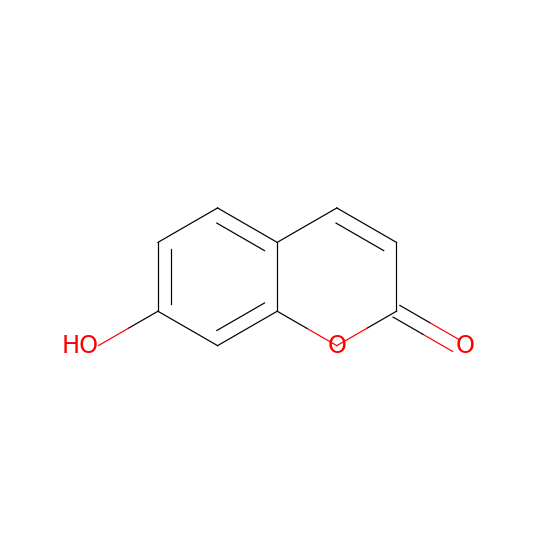

In [92]:
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib import pyplot as plt

def plot_molecule(smiles_string):
    molecule = Chem.MolFromSmiles(smiles_string)
    fig = Draw.MolToMPL(molecule)
    plt.axis('off')
    plt.show()
    
def plot_illustrative_mass_spectrum(spectrum, x_min, x_max):
    x = spectrum.peaks.mz
    y = spectrum.peaks.intensities
    fig, ax = plt.subplots()
    ax.bar(x, y)
    fig.patch.set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0,1.05)
    plt.show()

plot_molecule("O=C1OC=2C=C(O)C=CC2C=C1")



1
Tanimoto score query-analog:0.4110169491525424
precursor_mz*0.001                               5.744732e-01
mass_similarity                                 8.256967e-30
s2v_score                                       3.771210e-01
ms2ds_score                                     9.646188e-01
average_ms2ds_score_for_inchikey14              9.189554e-01
nr_of_spectra_with_same_inchikey14*0.01         3.900000e-01
closely_related_inchikey14s_score               8.399111e-01
average_tanimoto_for_closely_related_score      9.966789e-01
nr_of_spectra_for_closely_related_score*0.01    3.710000e+00
ms2query_model_prediction                       8.319132e-01
Name: CCMSLIB00003103023, dtype: float64
CCCCCCCCCCCCCCCC(=O)OC[C@H](CO[C@H]1C(C([C@H]([C@H](O1)CO[C@@H]2C(C([C@H]([C@H](O2)CO)O)O)O)O)O)O)OC(=O)CCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCC(=O)OC[C@H](CO)OC(=O)CCCCCCC/C=C\C/C=C\CCCCC


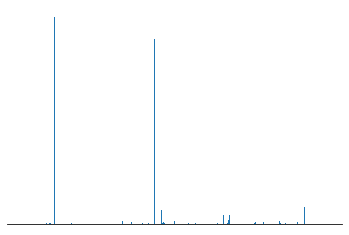

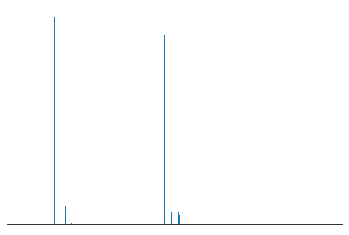

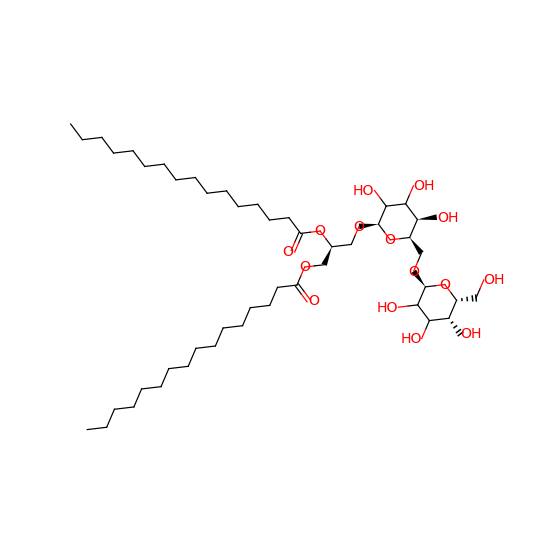

tanimoto_score_analog:1.0


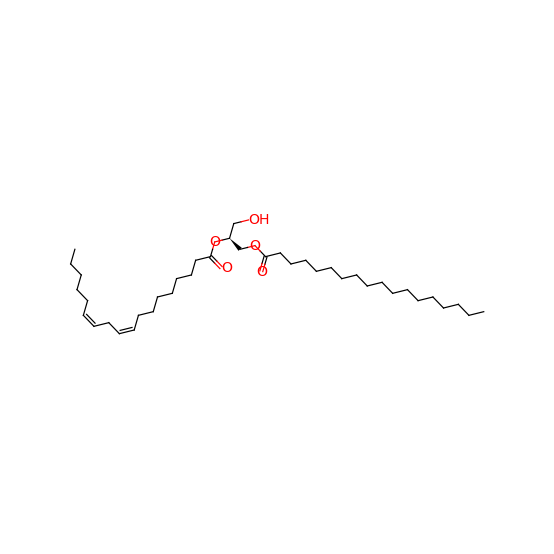

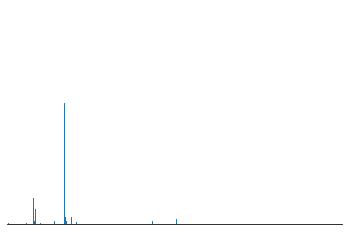

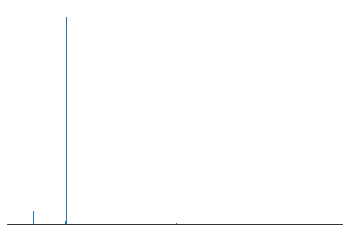

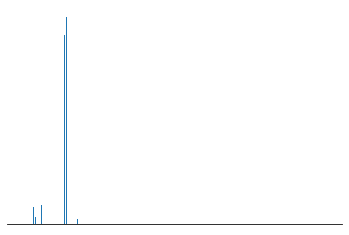

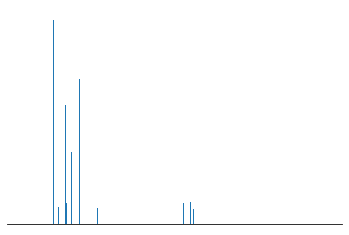

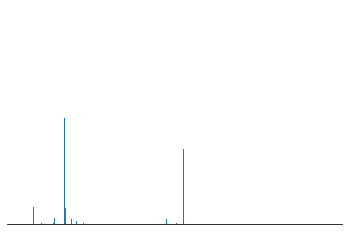

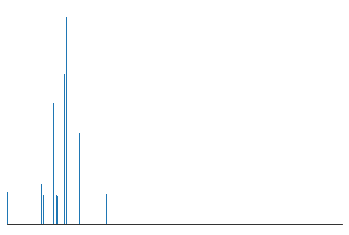

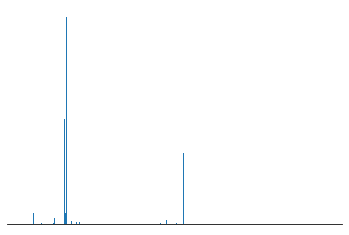

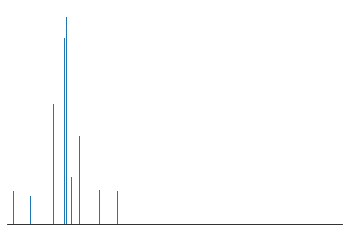

tanimoto_score_analog:1.0


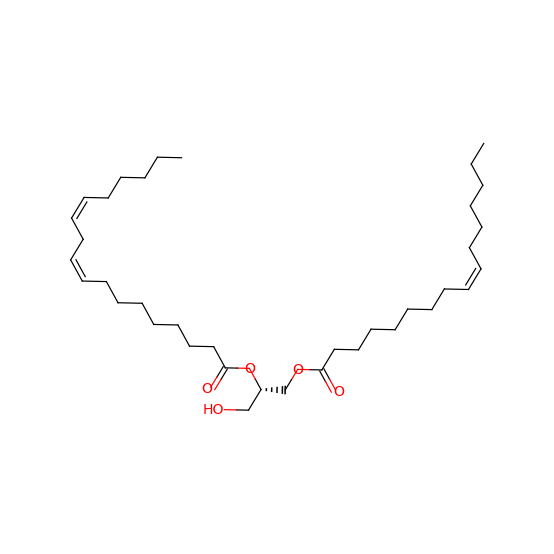

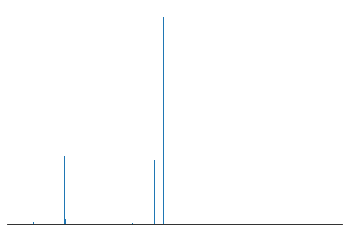

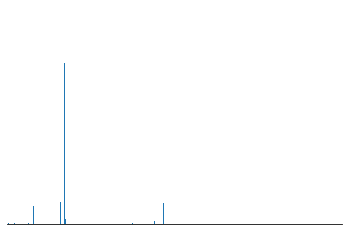

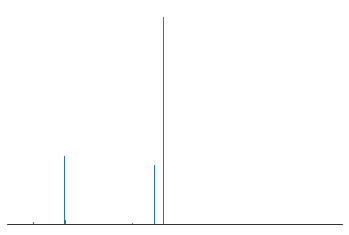

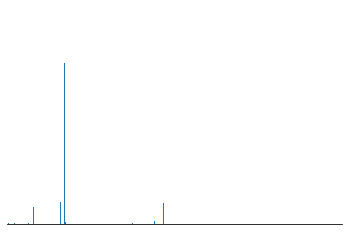

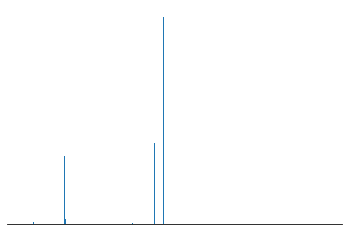

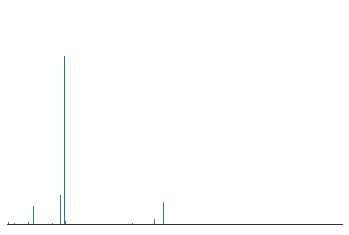

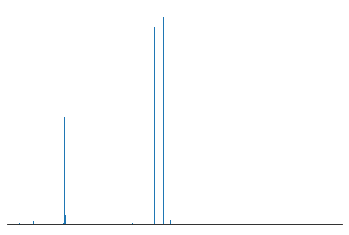

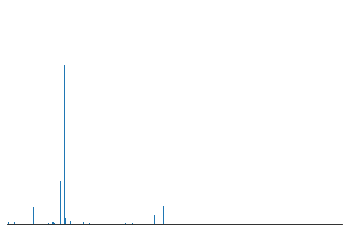

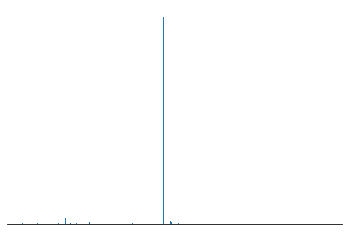

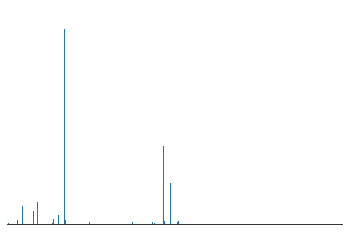

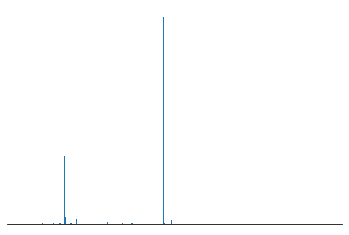

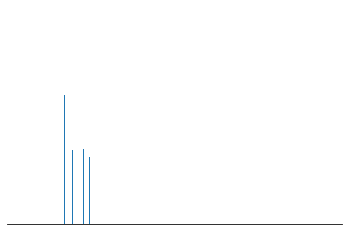

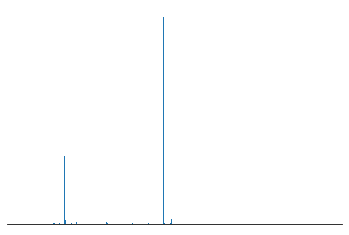

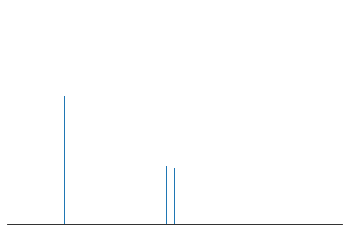

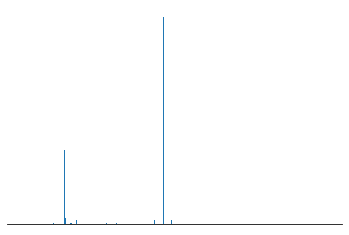

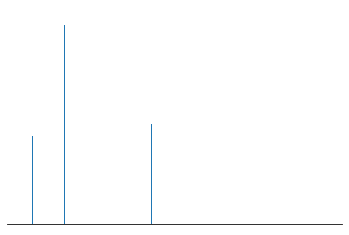

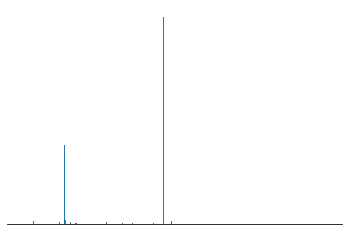

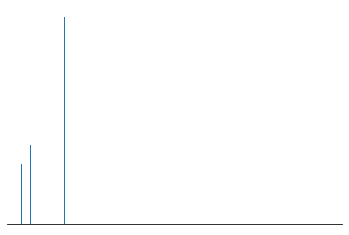

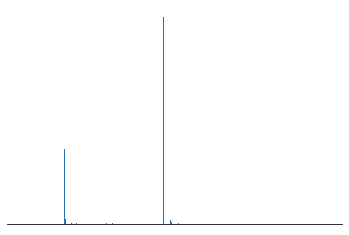

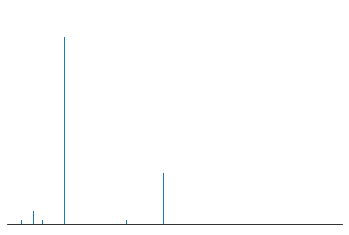

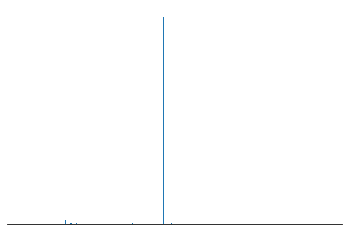

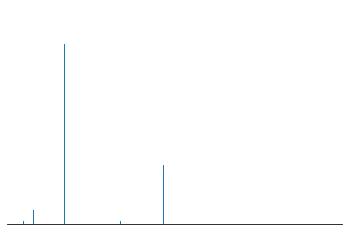

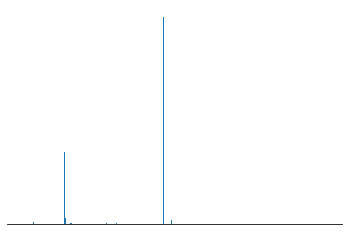

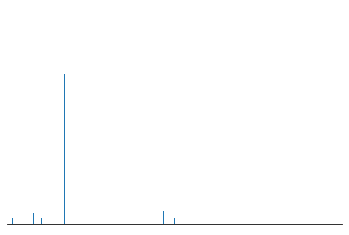

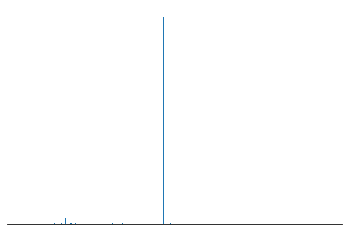

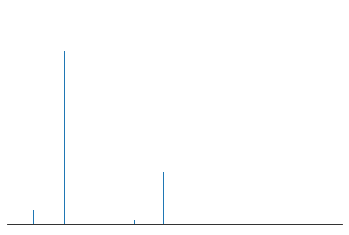

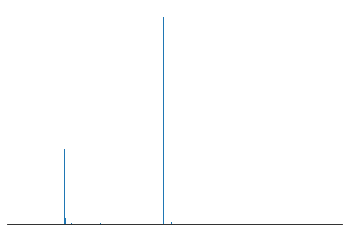

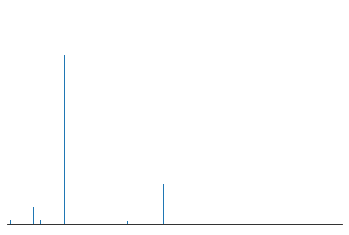

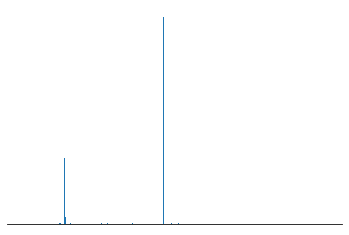

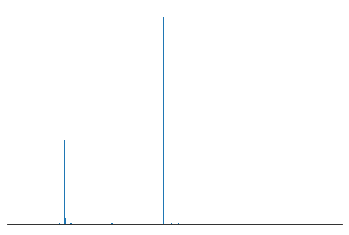

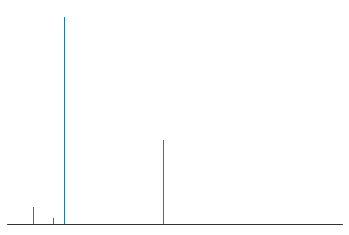

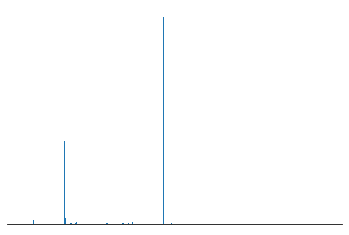

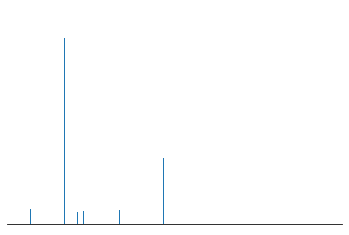

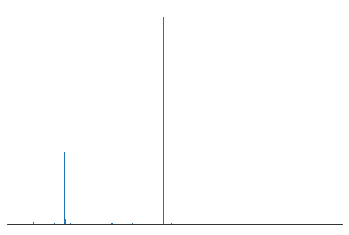

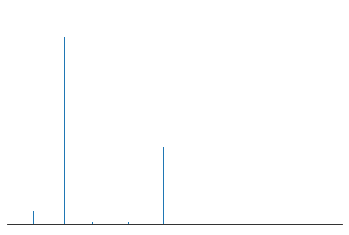

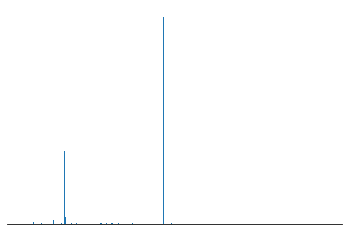

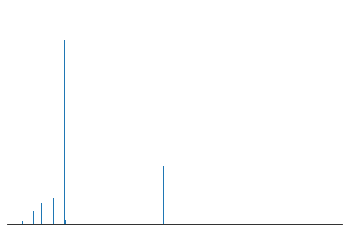

tanimoto_score_analog:1.0


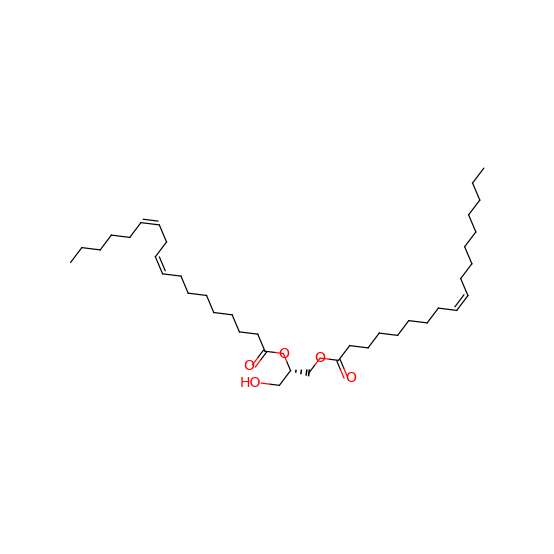

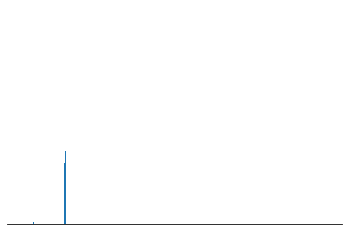

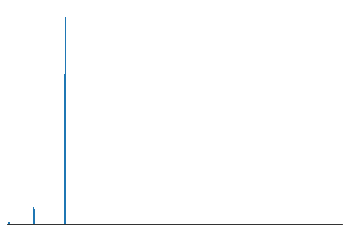

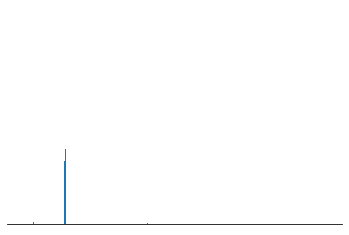

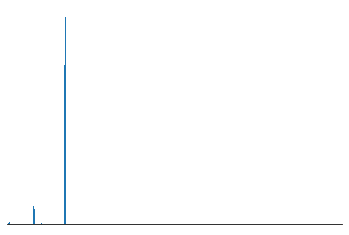

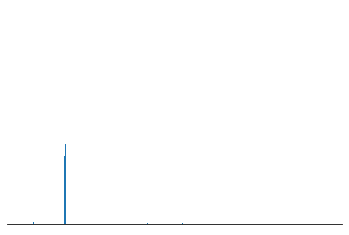

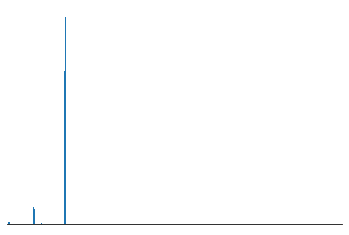

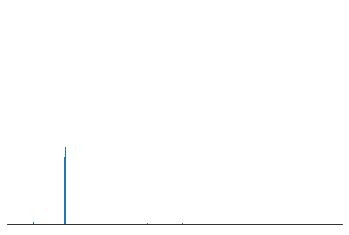

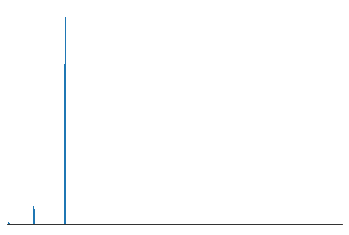

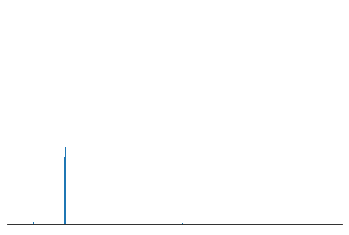

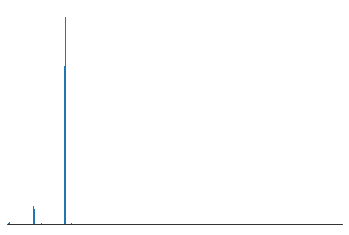

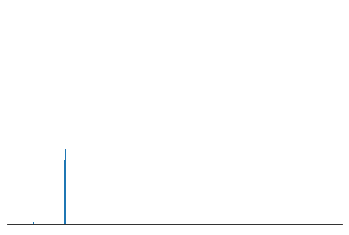

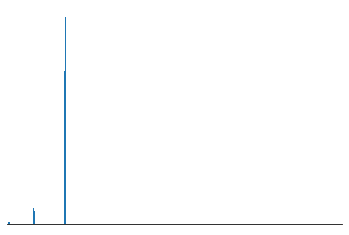

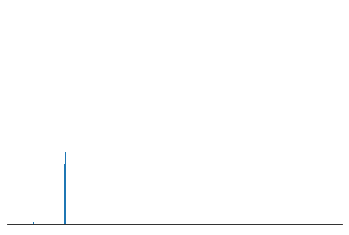

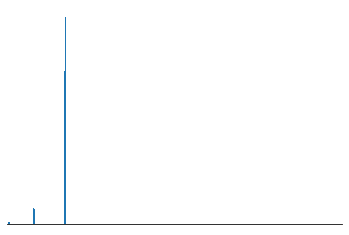

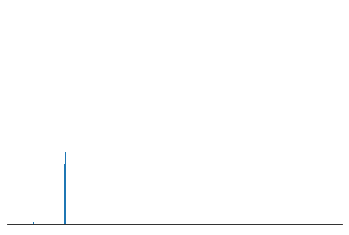

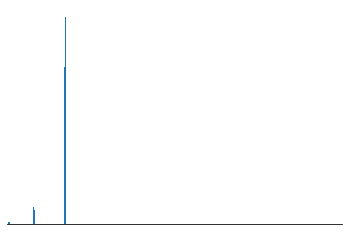

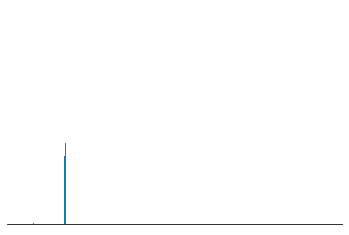

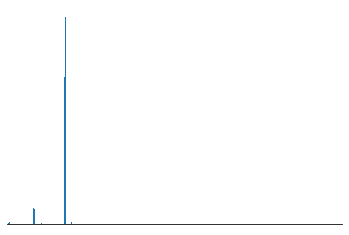

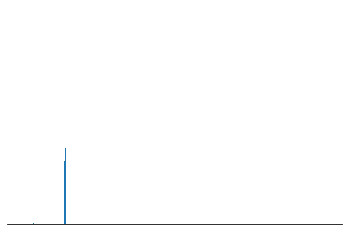

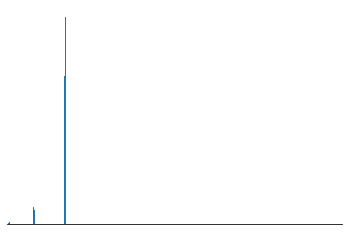

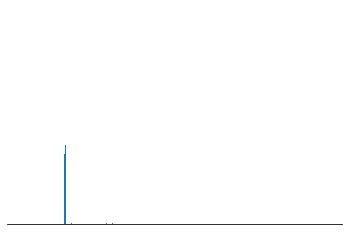

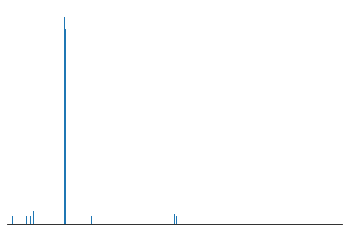

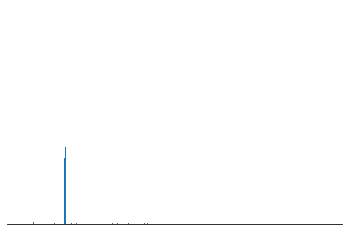

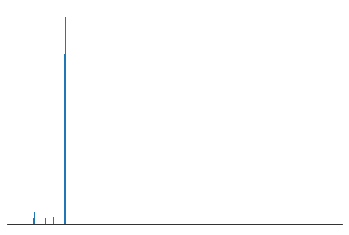

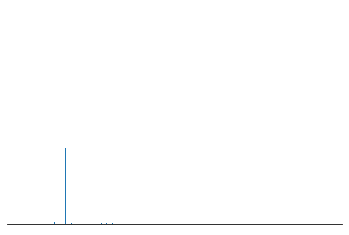

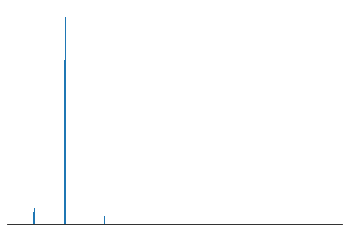

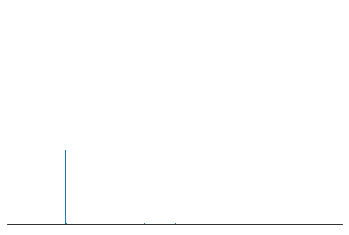

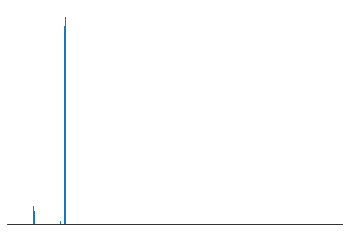

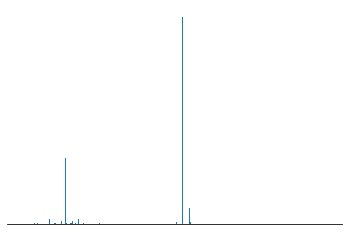

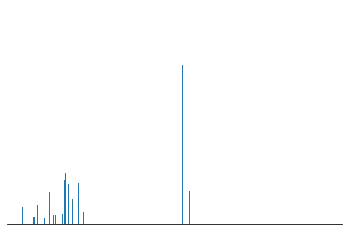

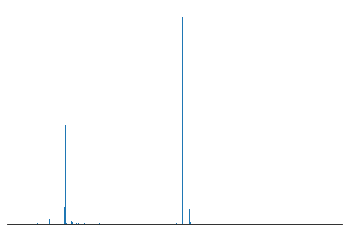

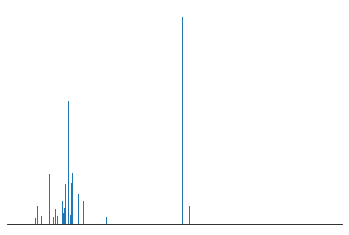

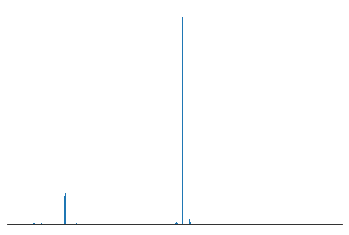

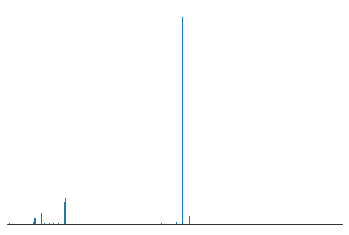

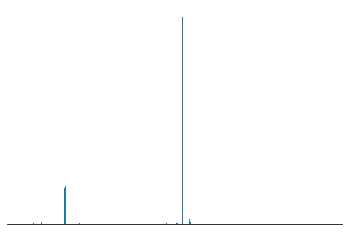

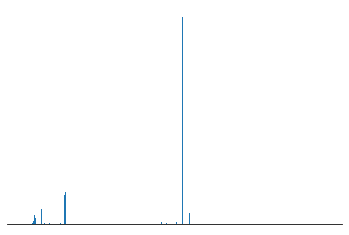

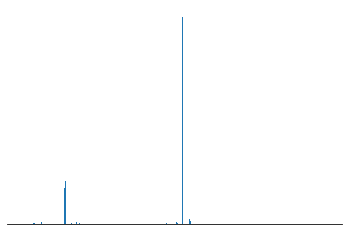

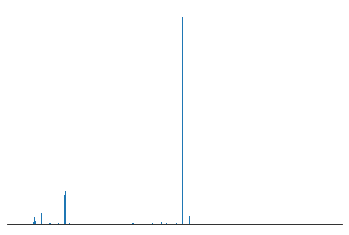

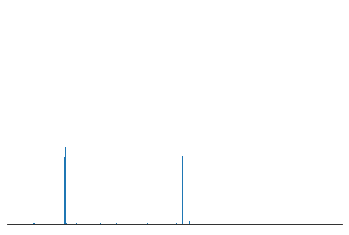

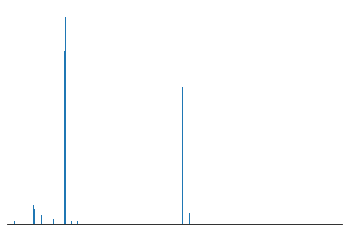

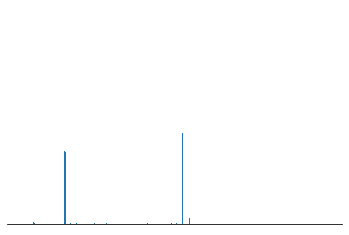

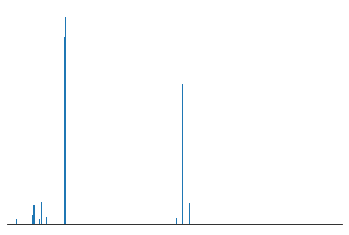

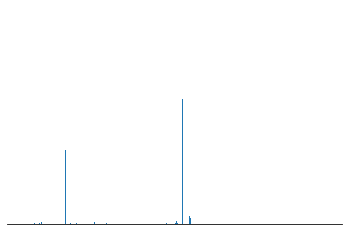

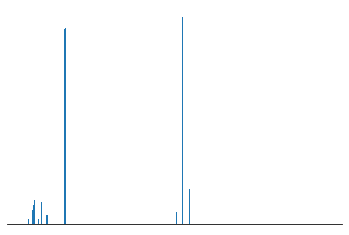

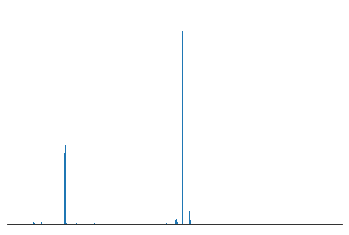

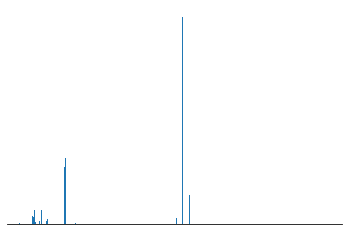

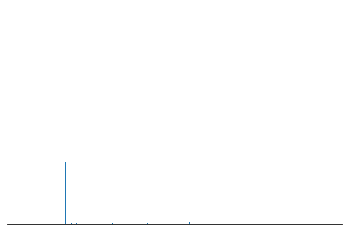

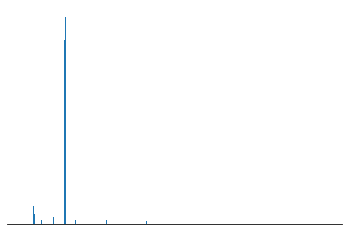

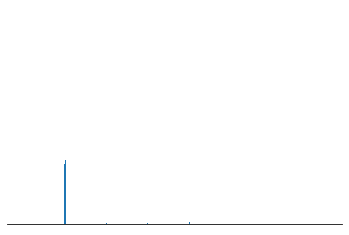

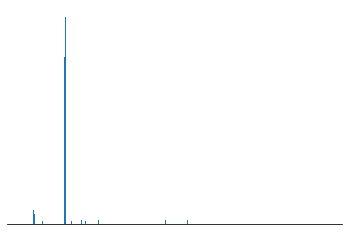

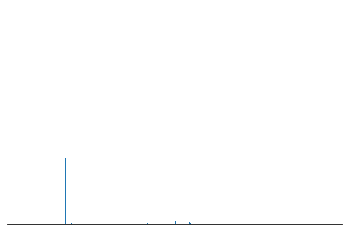

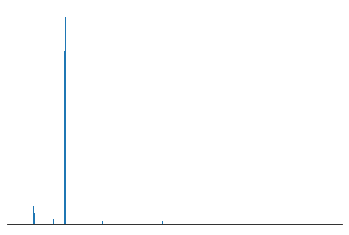

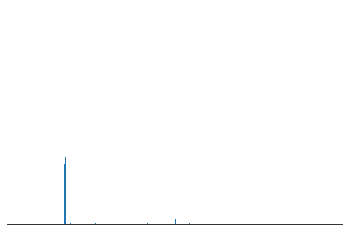

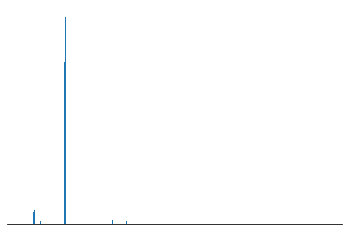

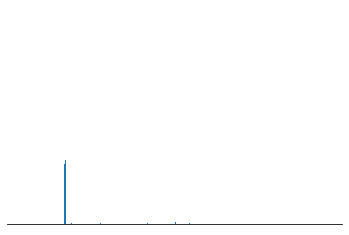

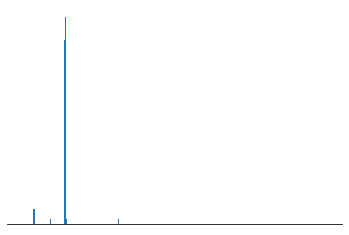

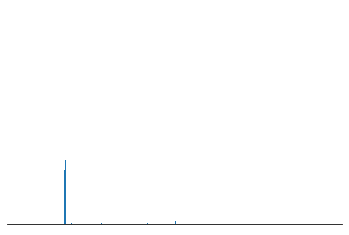

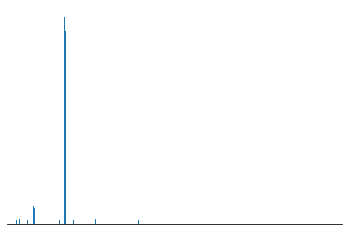

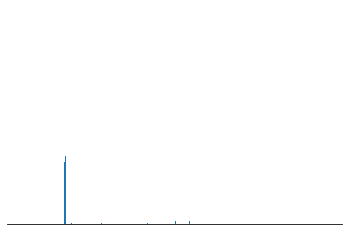

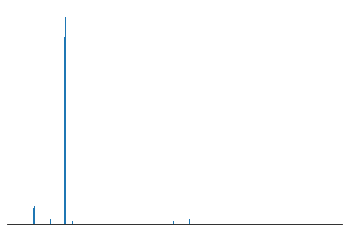

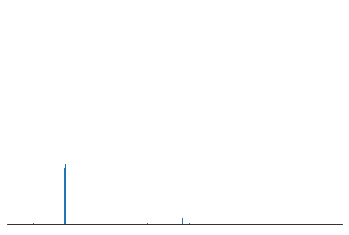

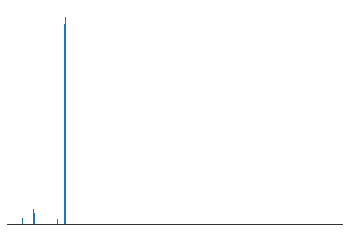

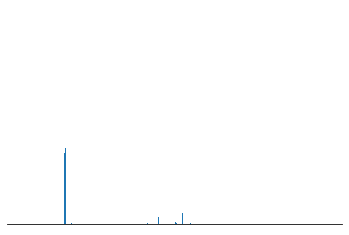

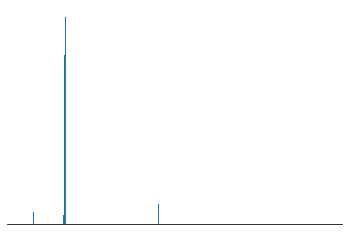

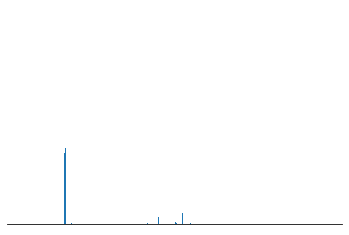

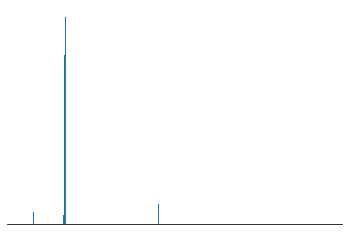

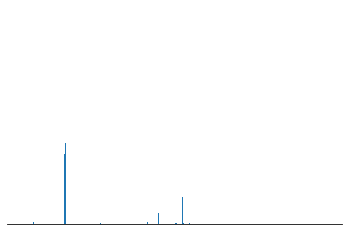

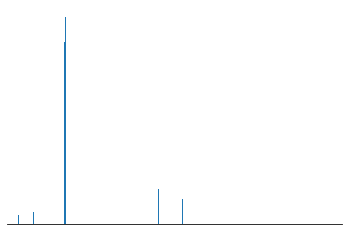

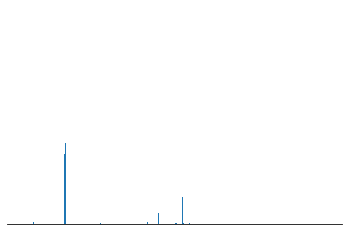

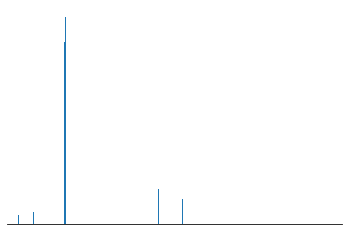

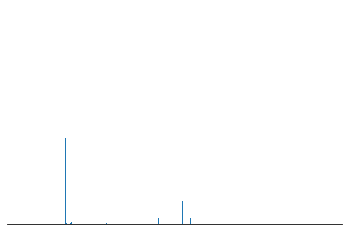

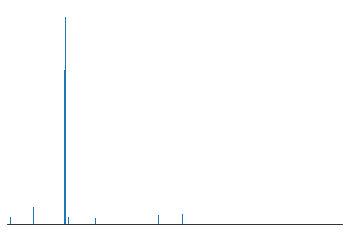

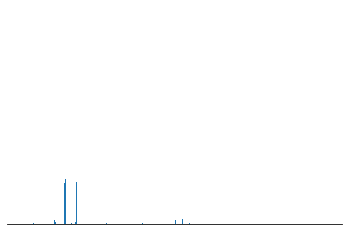

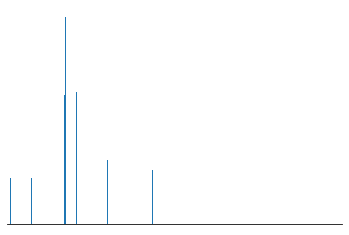

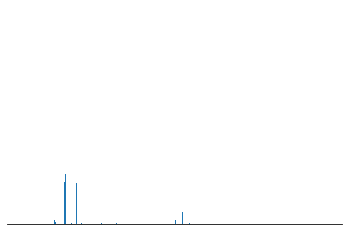

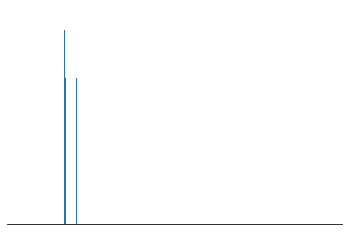

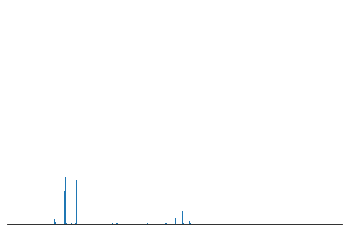

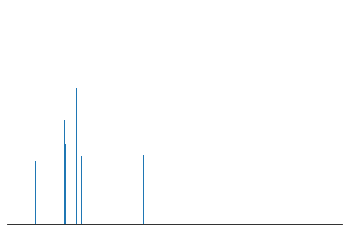

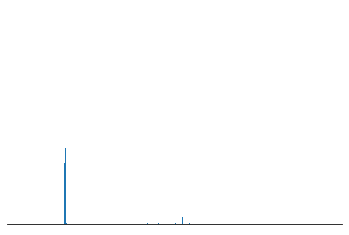

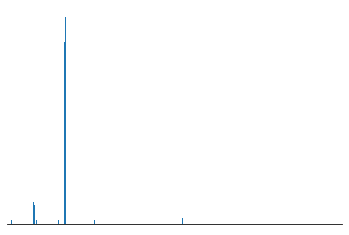

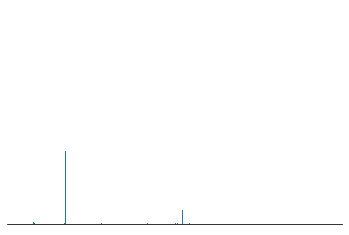

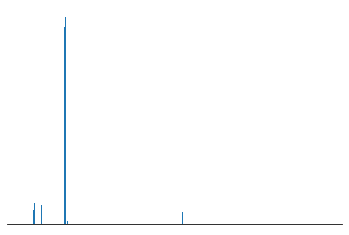

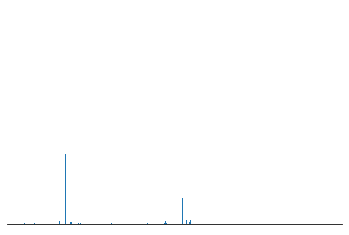

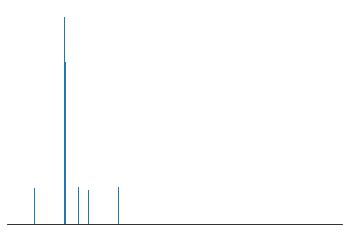

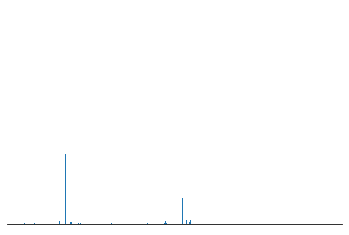

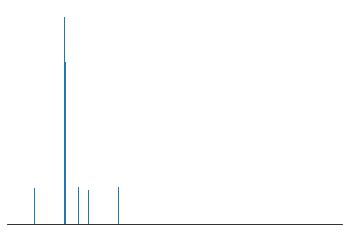

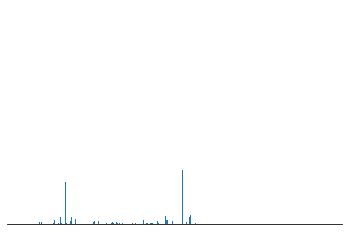

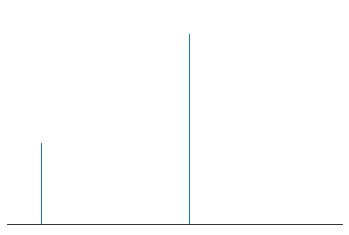

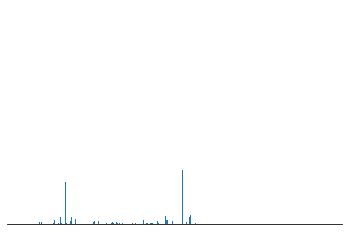

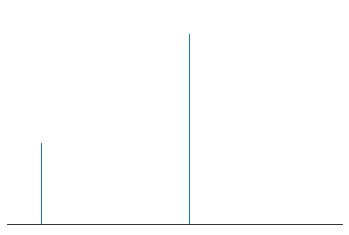

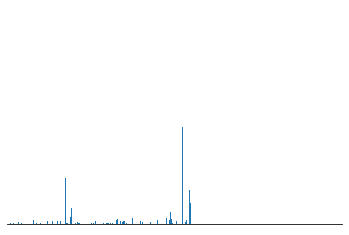

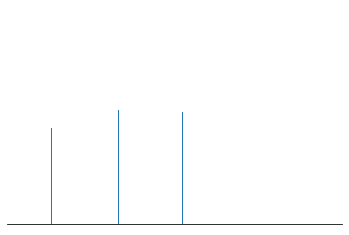

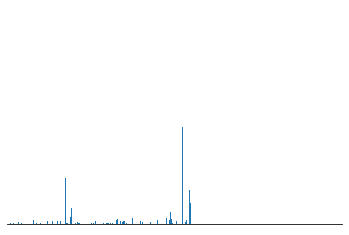

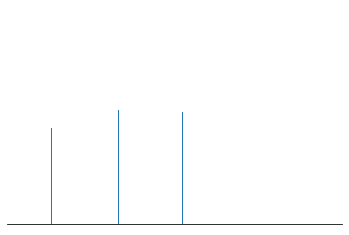

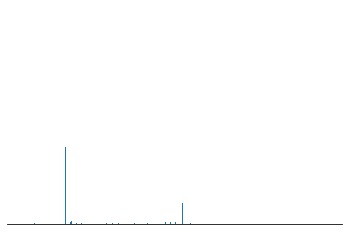

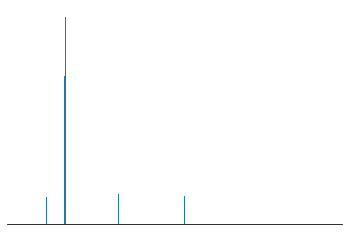

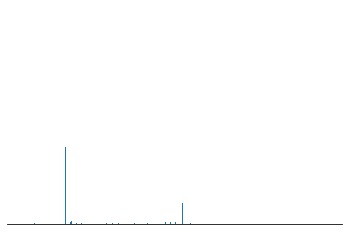

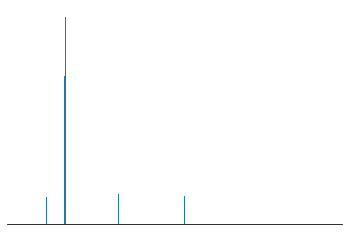

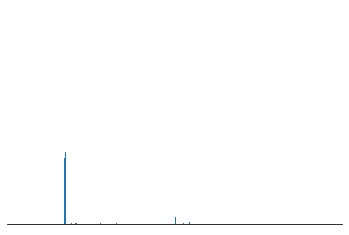

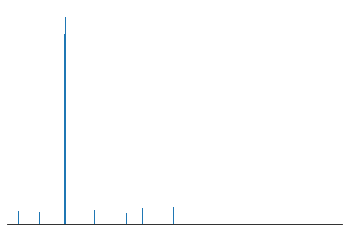

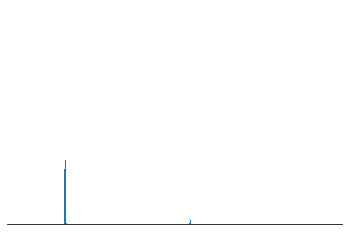

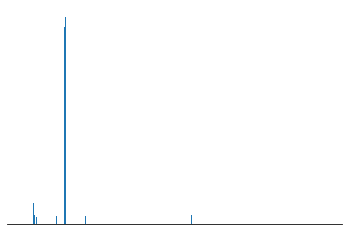

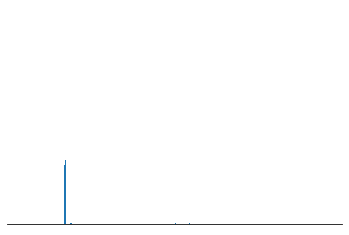

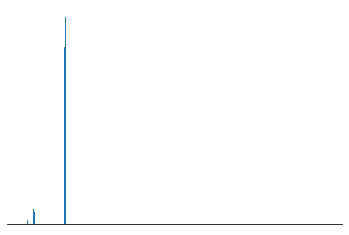

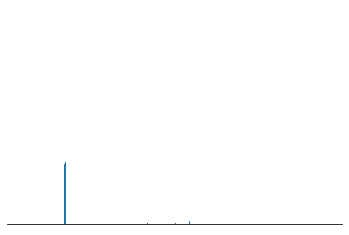

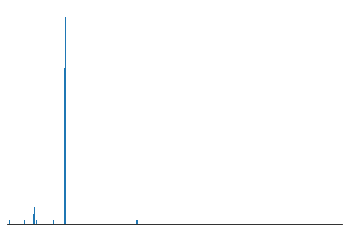

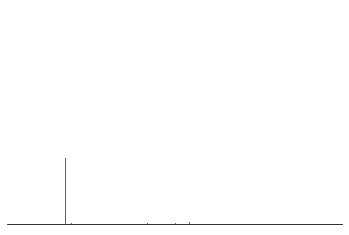

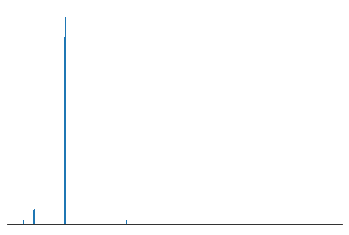

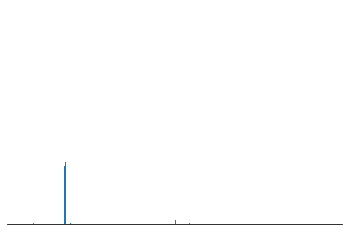

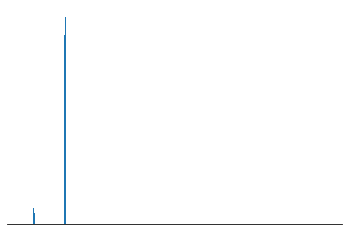

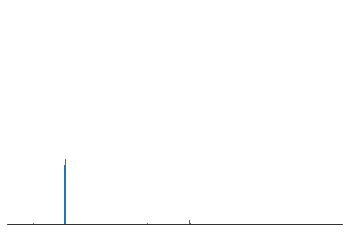

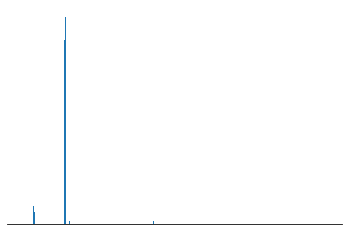

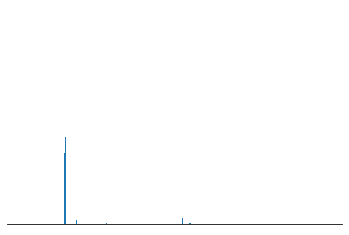

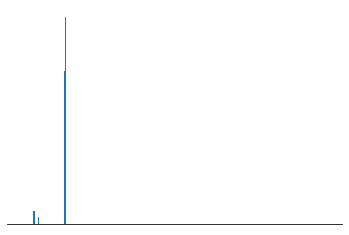

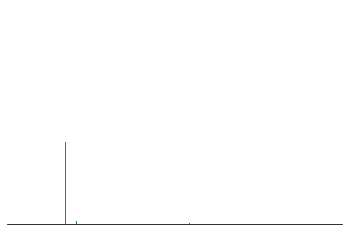

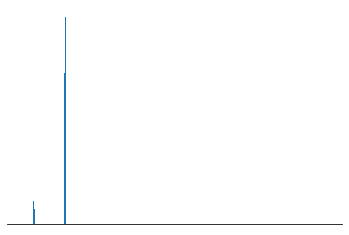

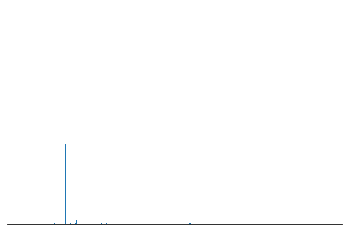

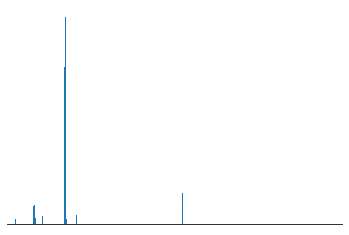

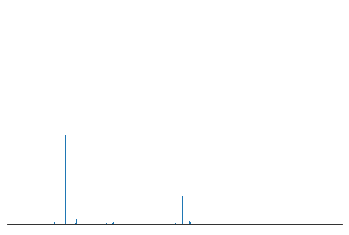

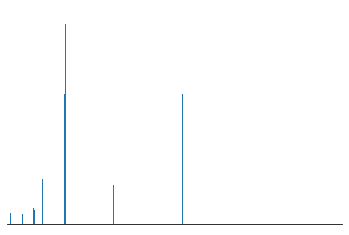

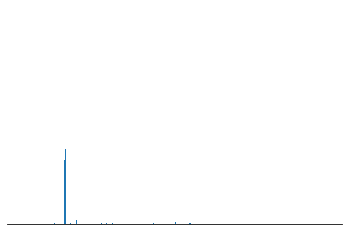

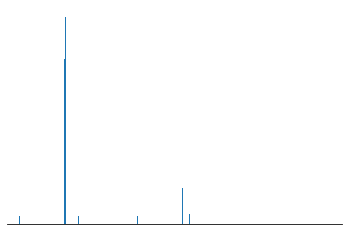

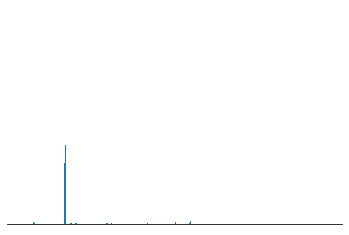

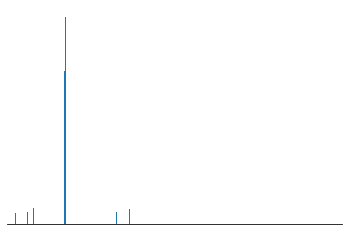

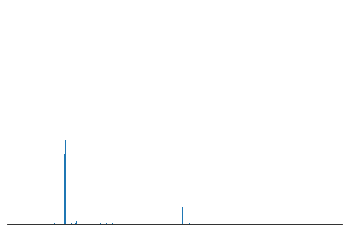

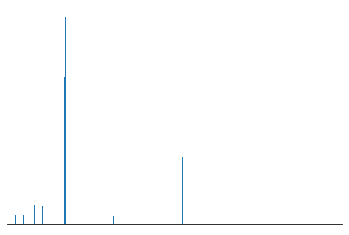

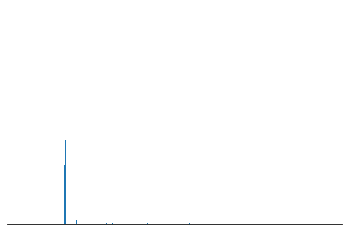

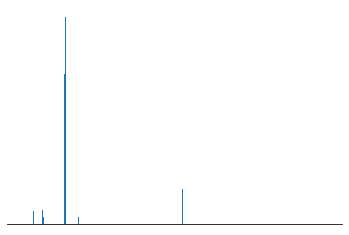

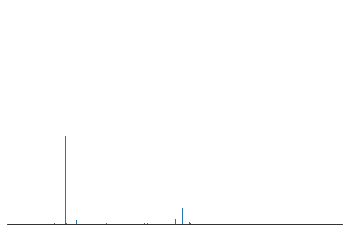

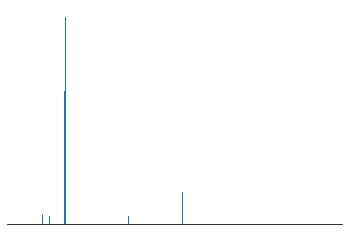

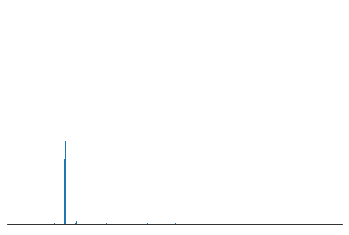

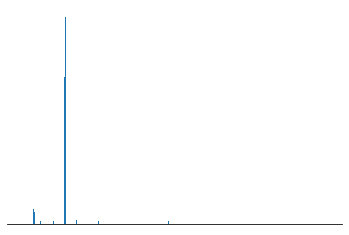

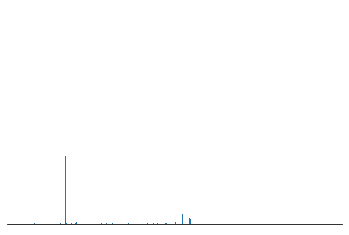

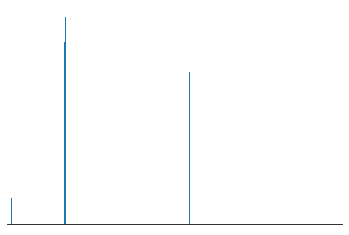

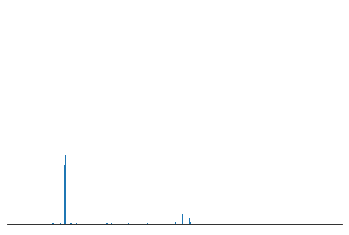

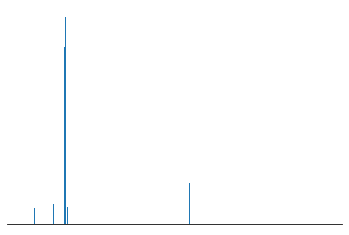

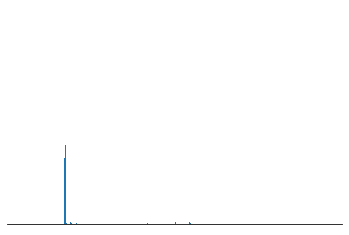

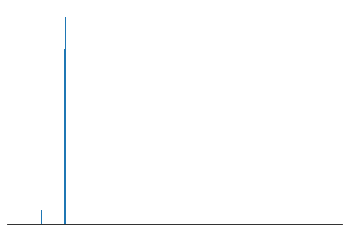

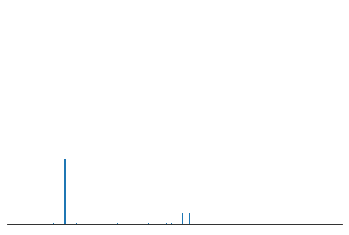

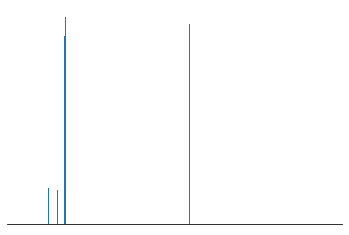

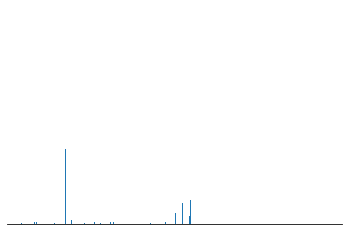

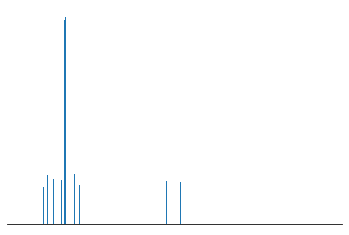

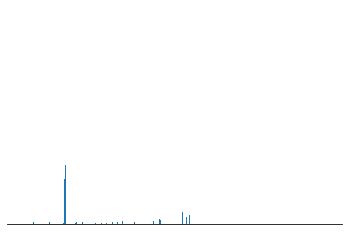

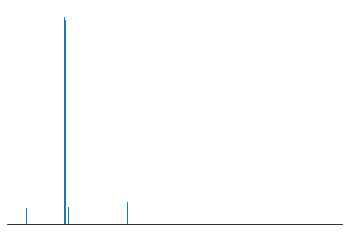

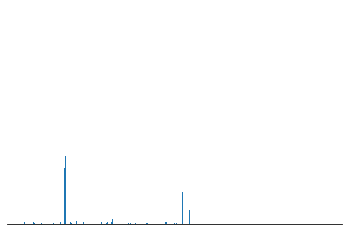

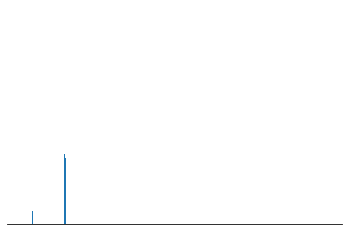

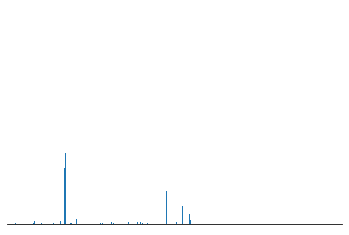

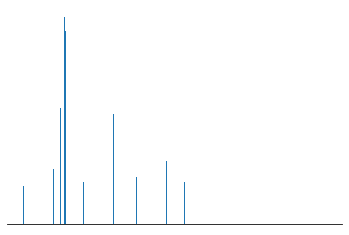

tanimoto_score_analog:1.0


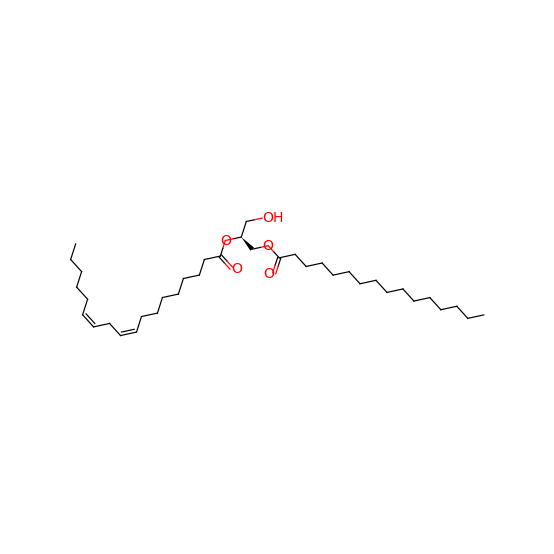

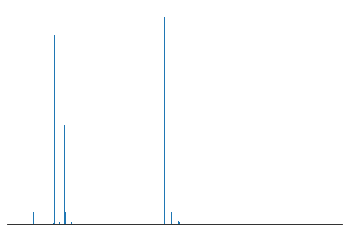

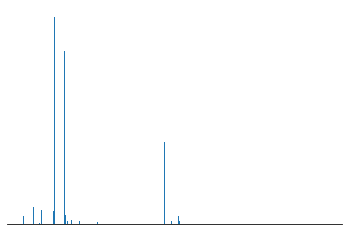

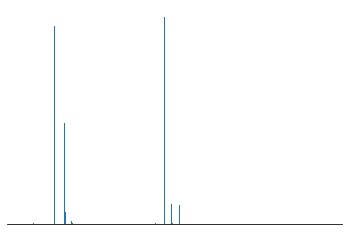

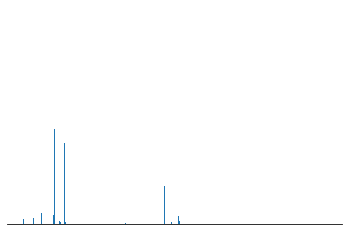

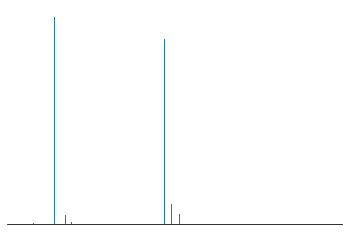

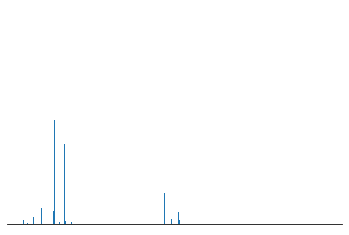

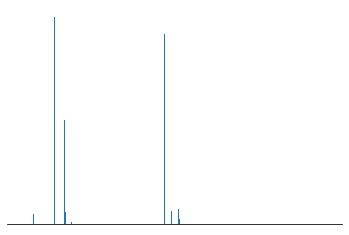

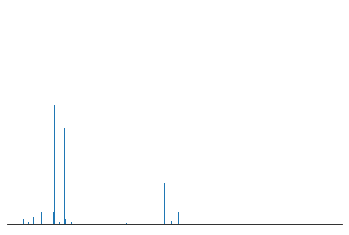

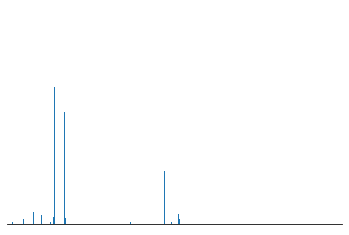

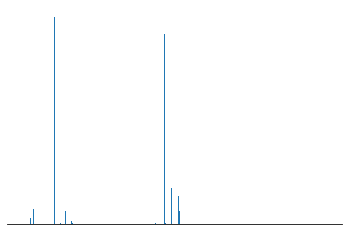

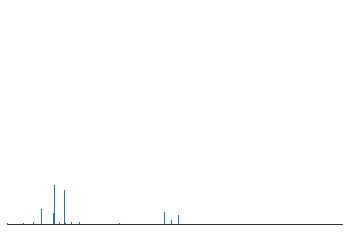

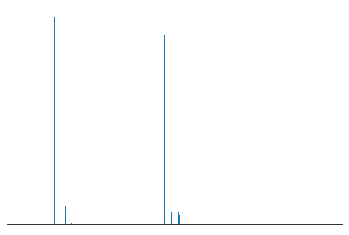

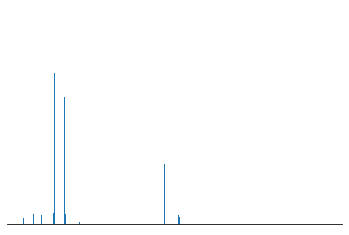

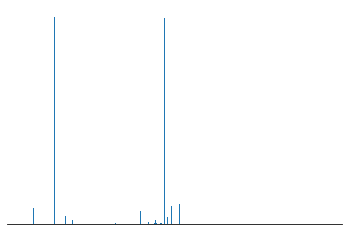

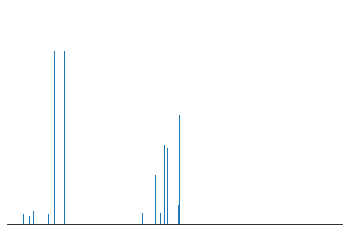

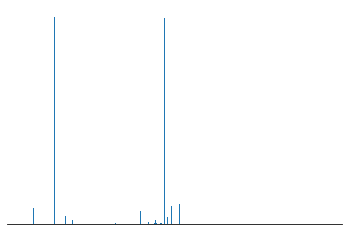

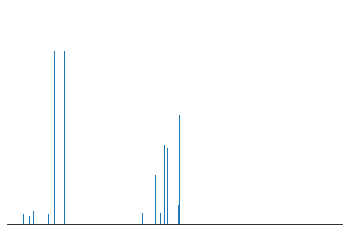

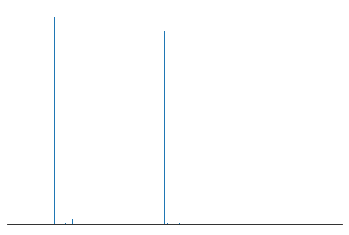

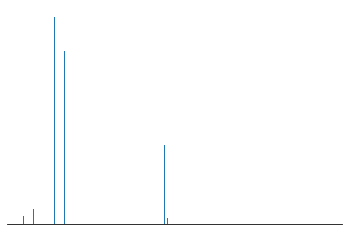

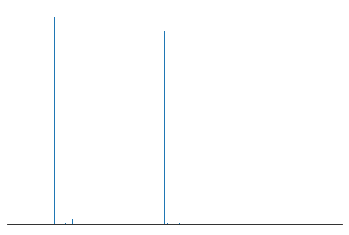

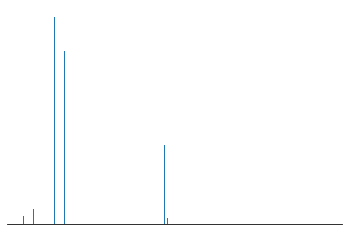

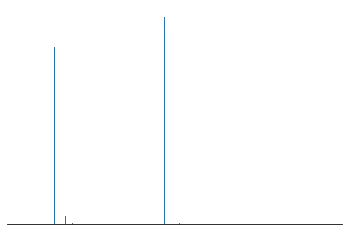

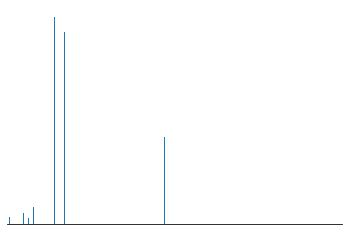

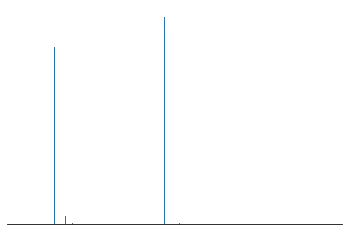

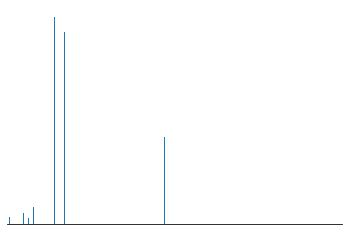

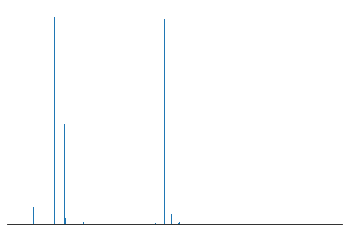

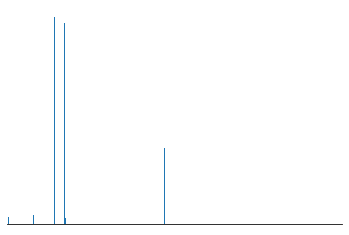

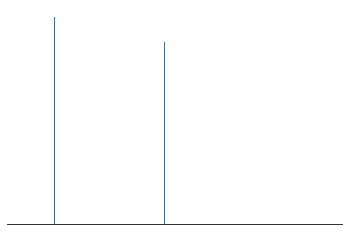

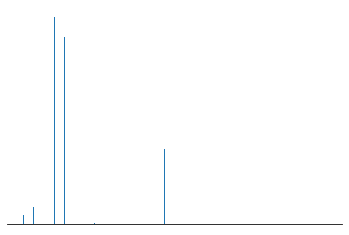

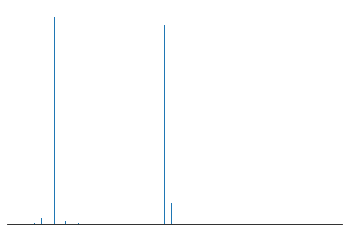

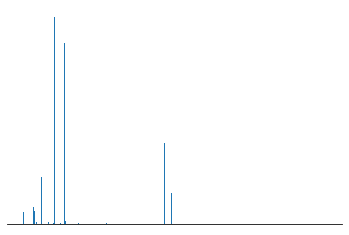

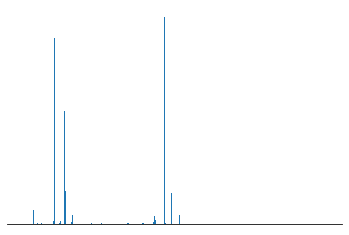

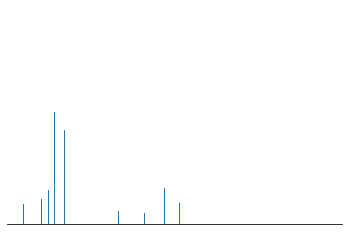

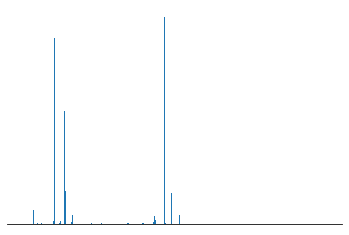

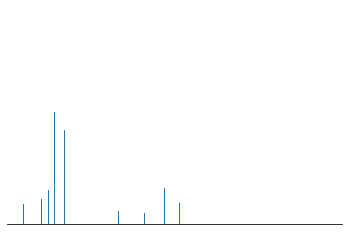

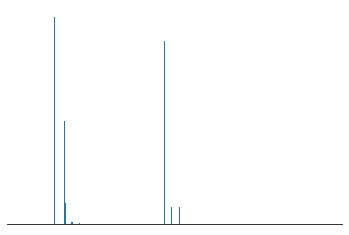

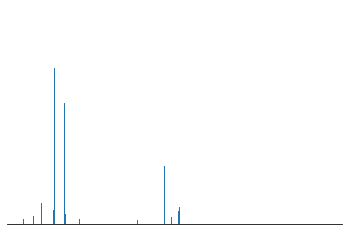

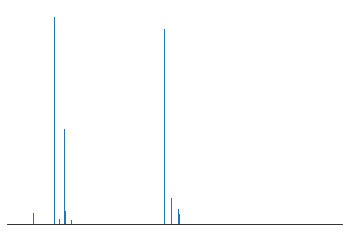

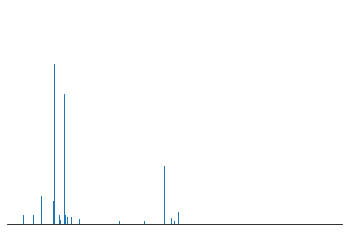

tanimoto_score_analog:1.0


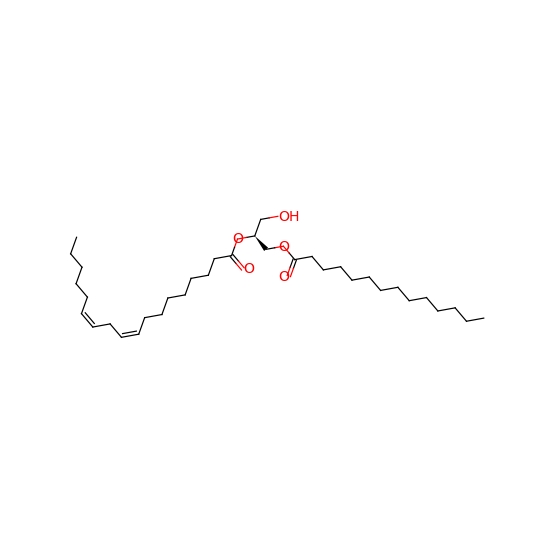

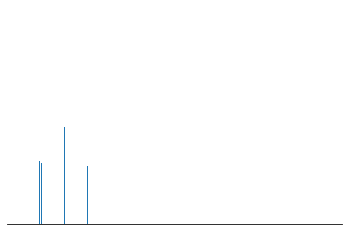

tanimoto_score_analog:0.9910714285714286


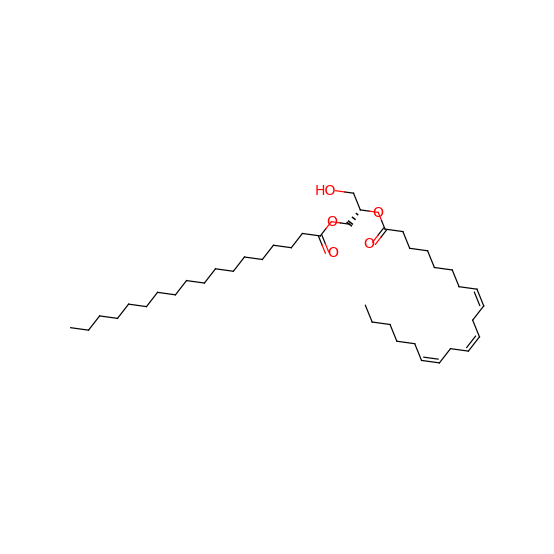

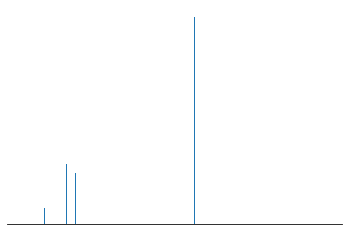

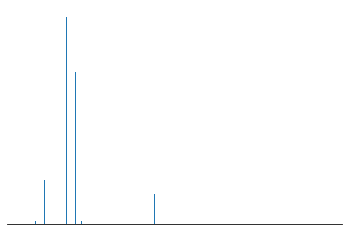

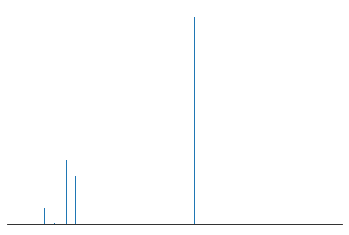

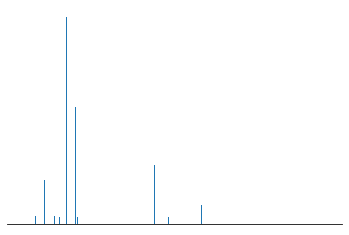

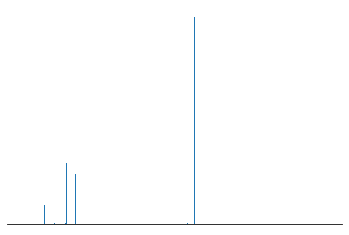

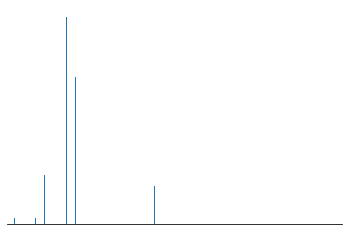

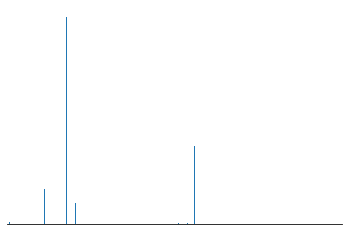

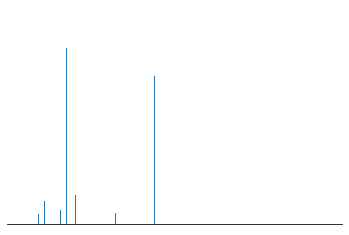

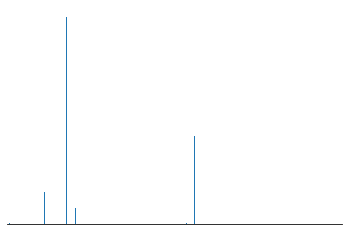

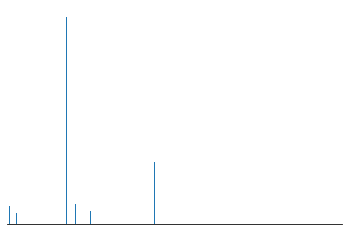

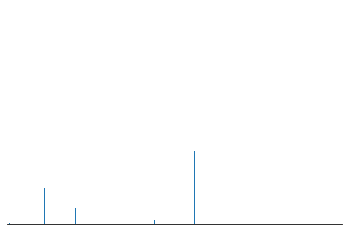

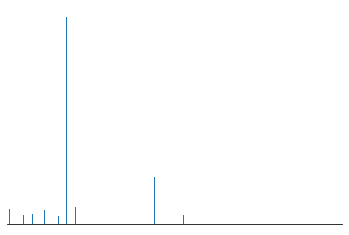

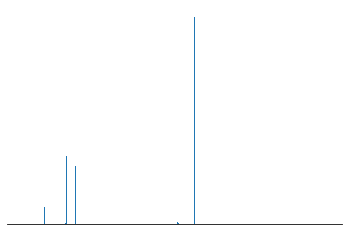

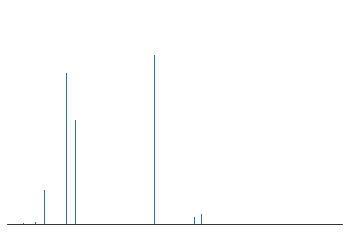

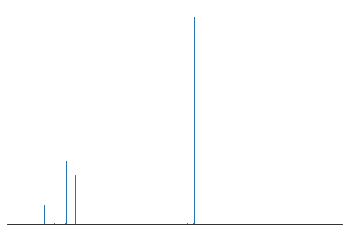

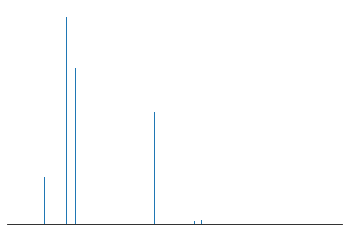

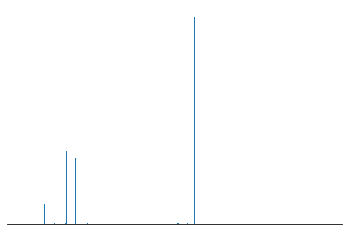

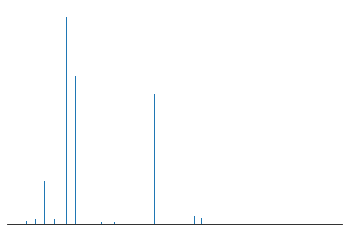

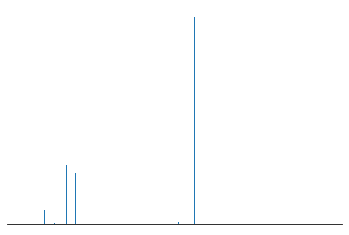

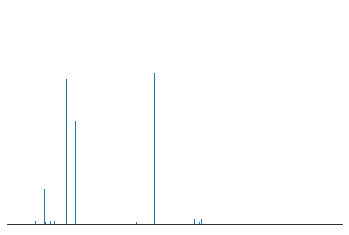

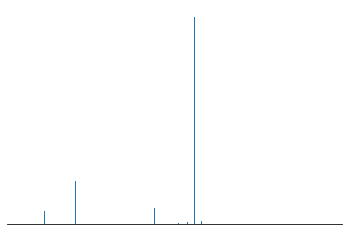

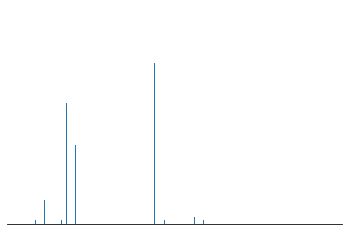

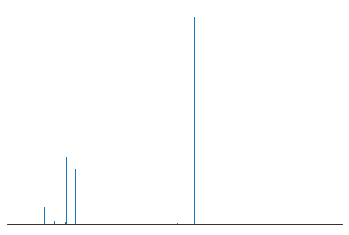

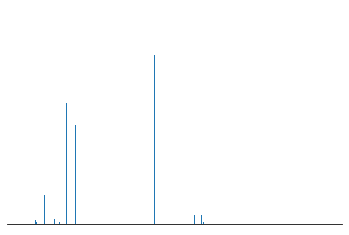

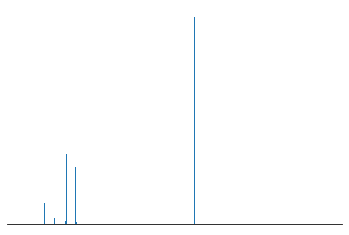

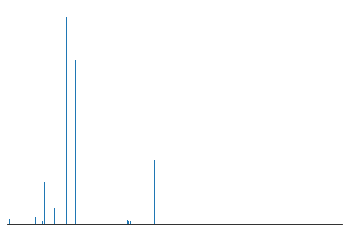

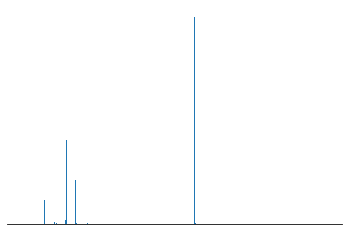

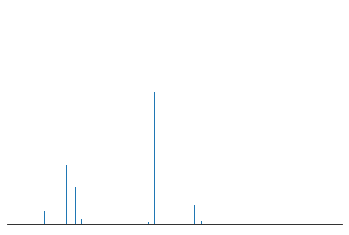

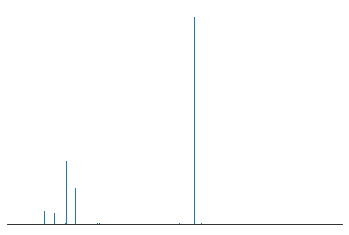

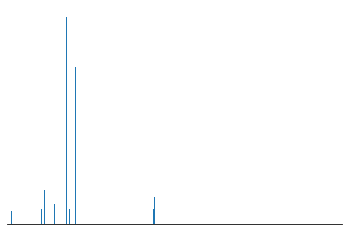

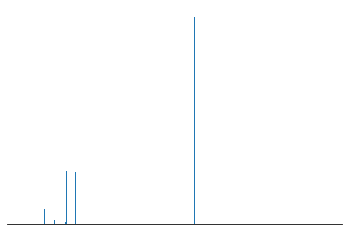

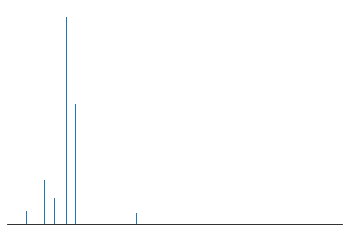

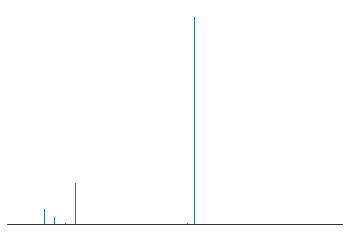

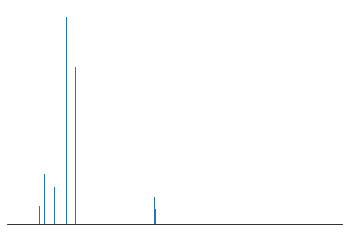

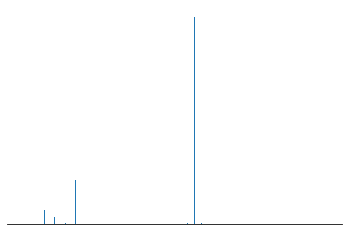

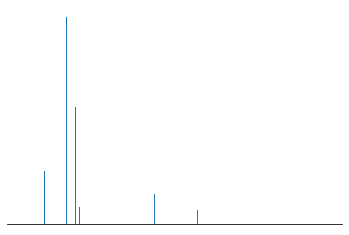

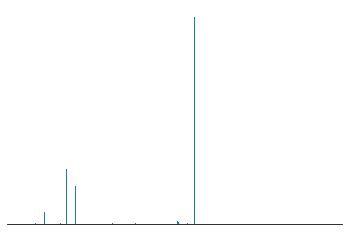

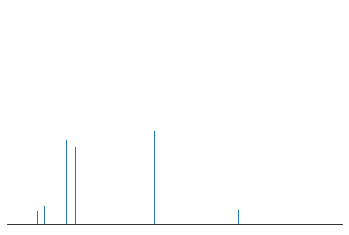

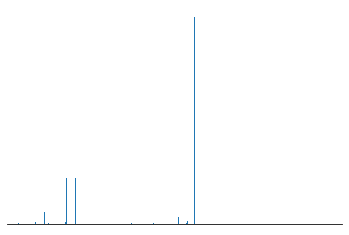

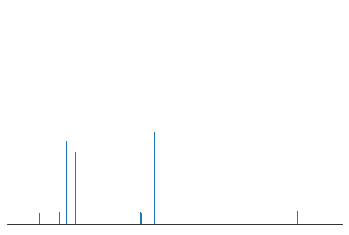

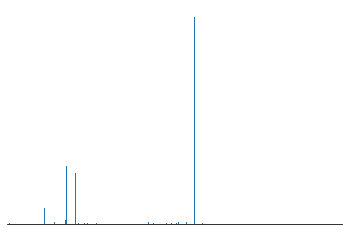

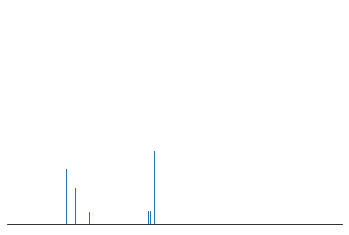

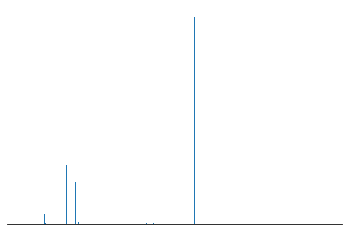

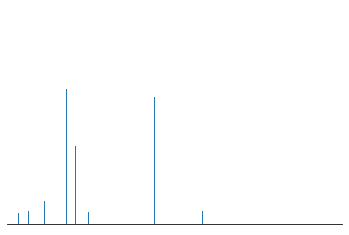

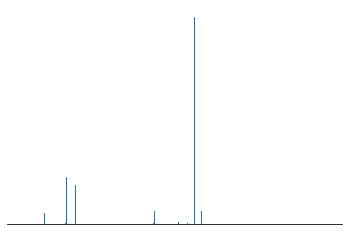

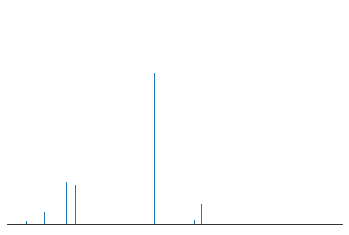

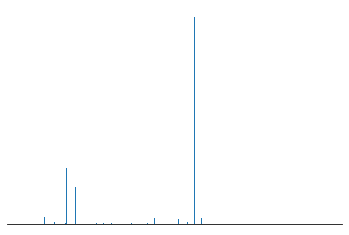

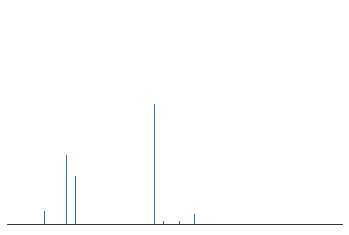

tanimoto_score_analog:0.9910714285714286


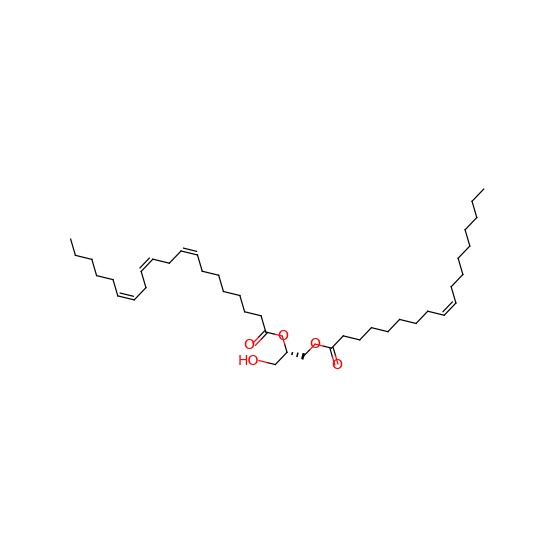

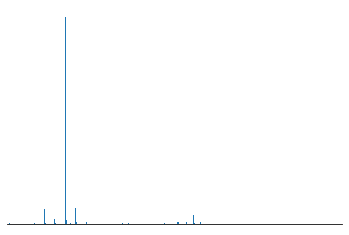

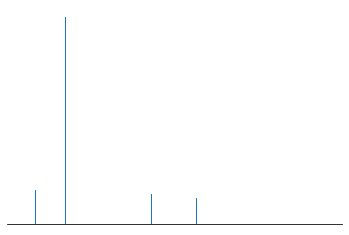

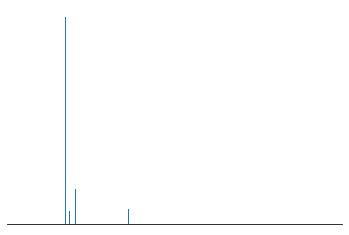

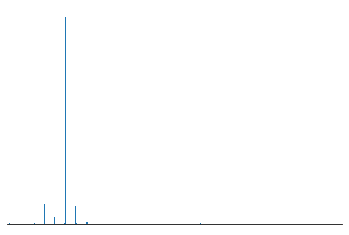

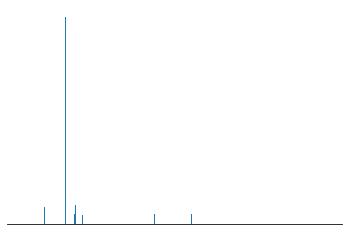

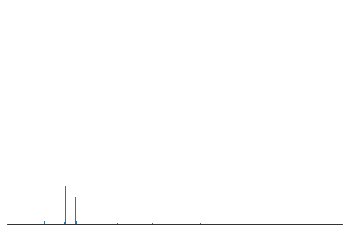

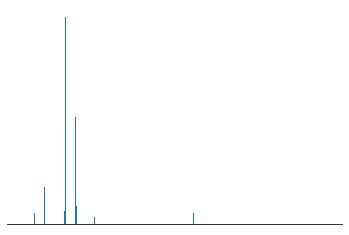

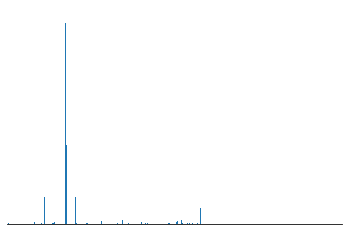

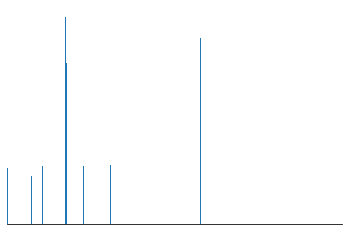

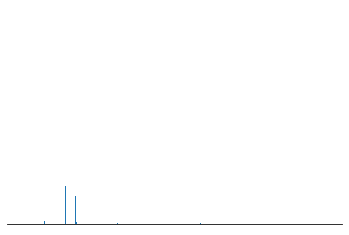

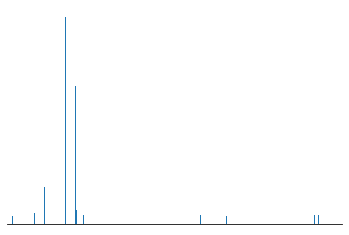

tanimoto_score_analog:0.9910714285714286


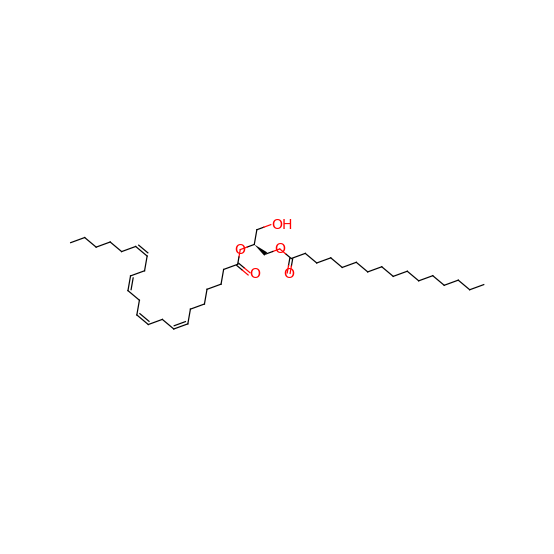

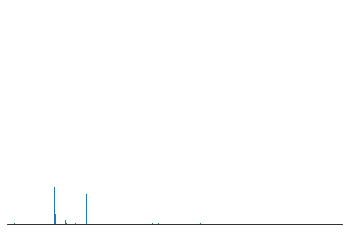

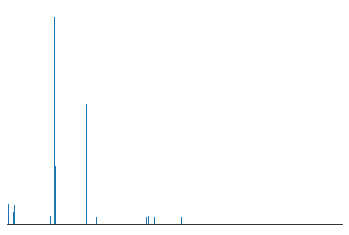

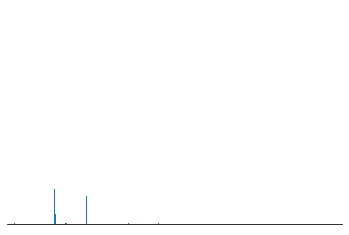

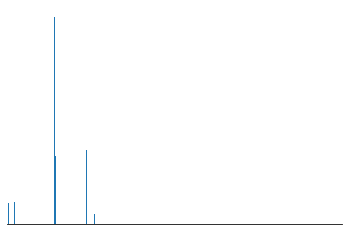

tanimoto_score_analog:0.9910714285714286


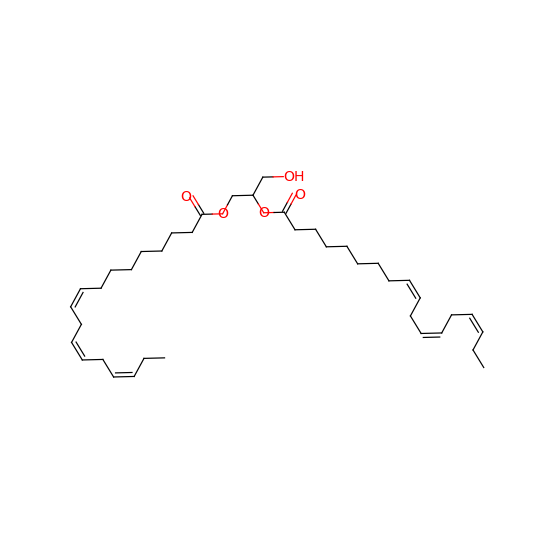

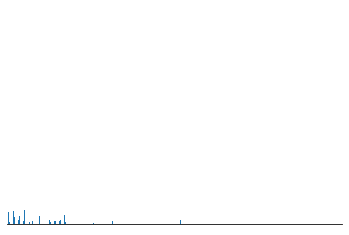

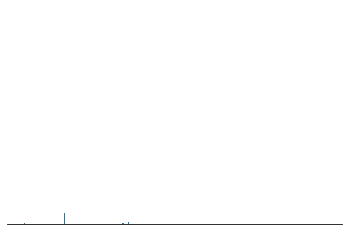

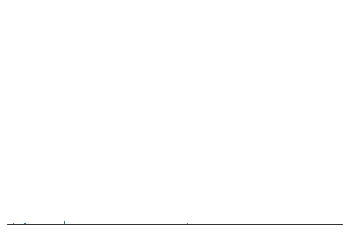

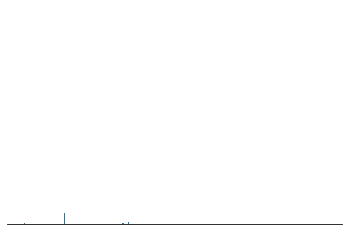

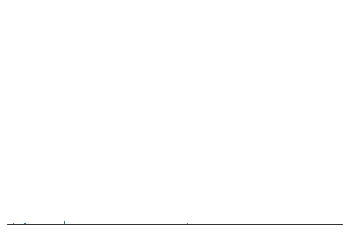

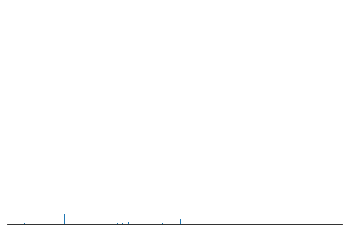

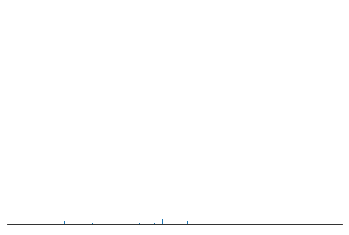

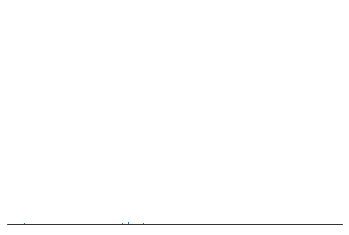

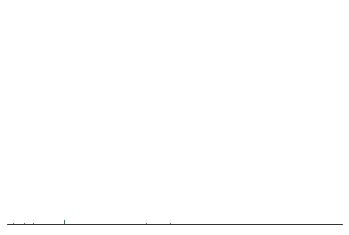

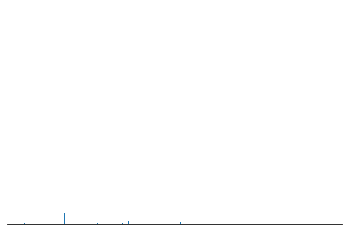

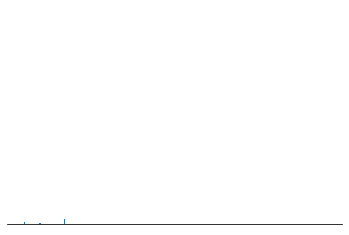

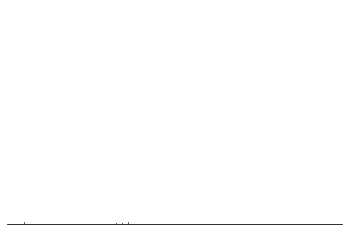

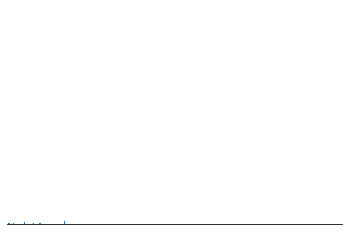

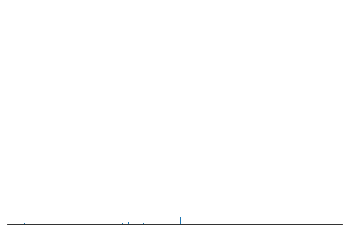

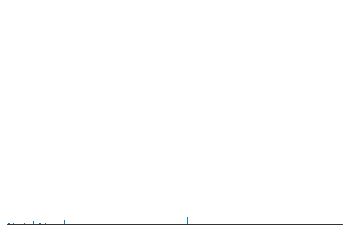

tanimoto_score_analog:0.9910714285714286


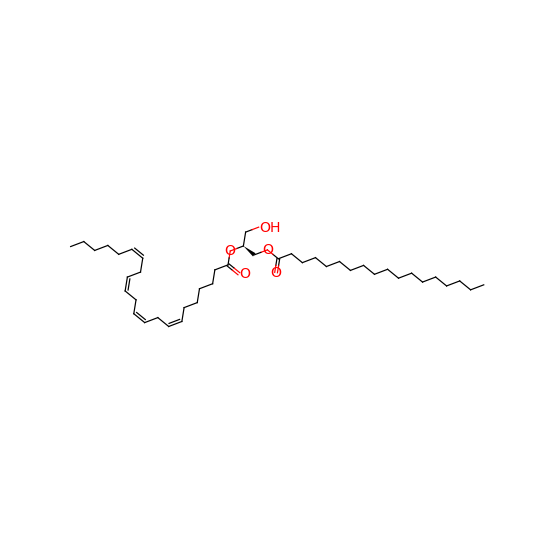

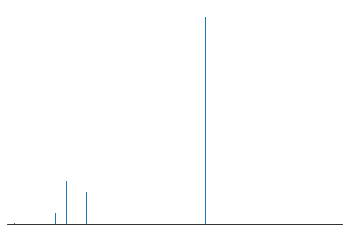

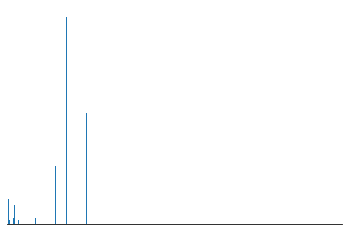

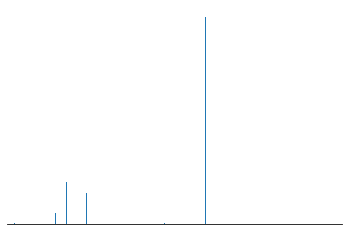

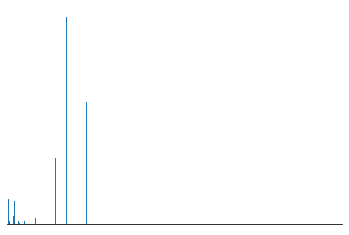

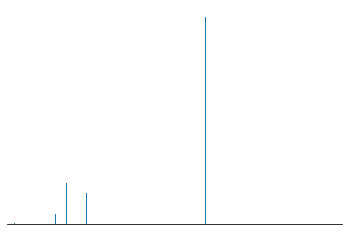

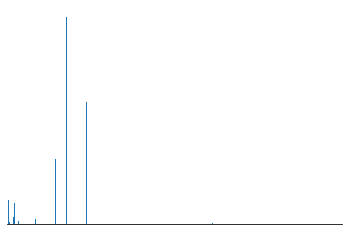

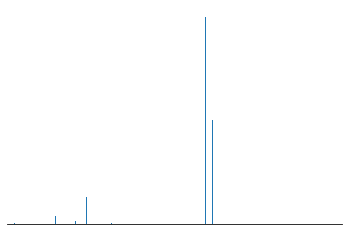

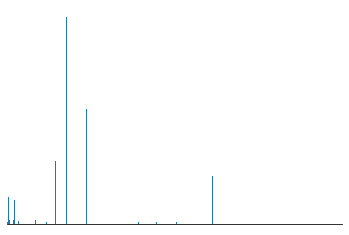

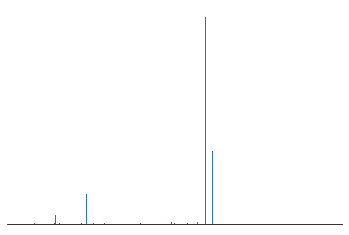

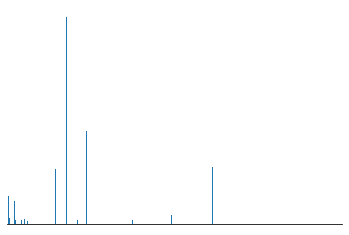

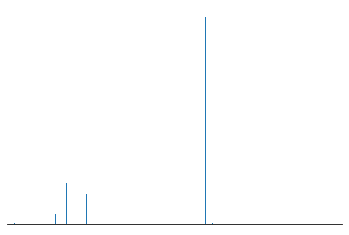

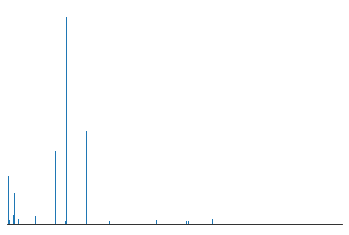

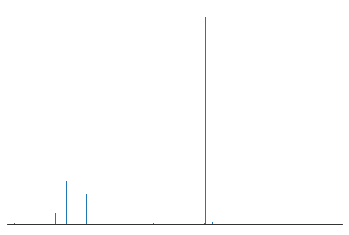

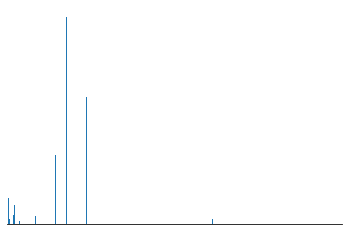

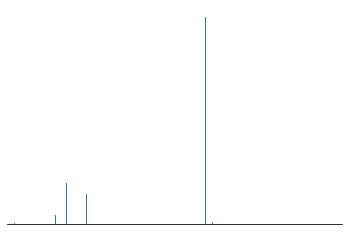

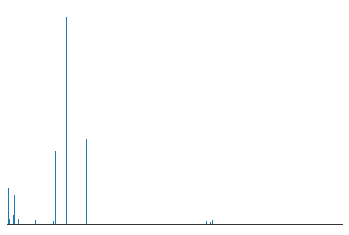

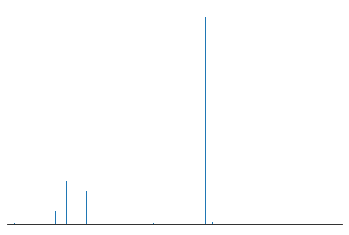

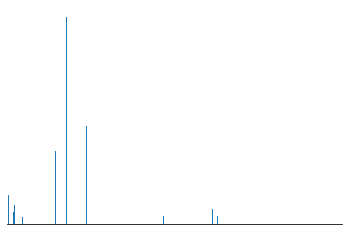

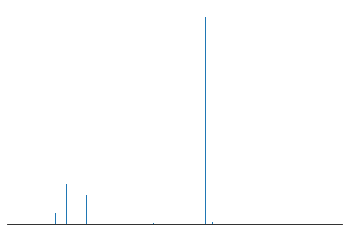

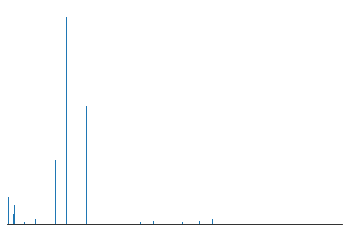

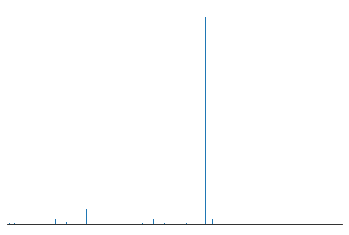

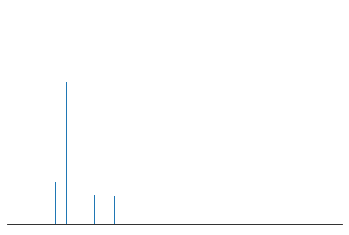

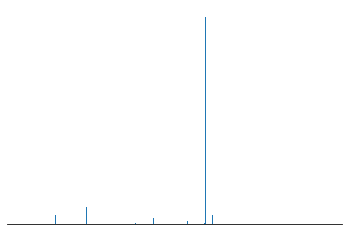

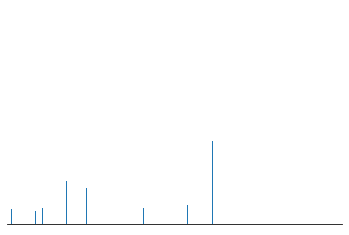

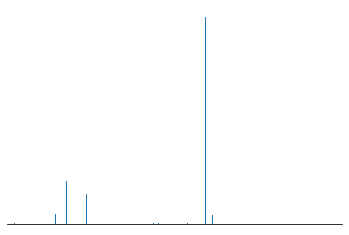

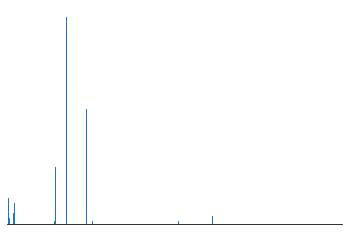

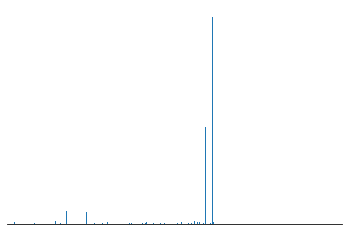

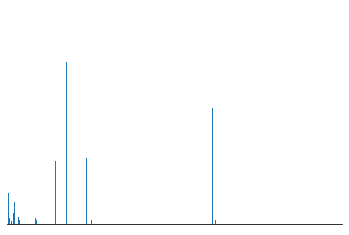

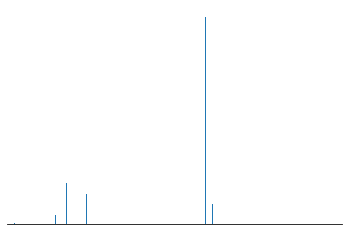

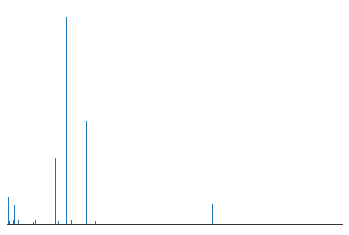

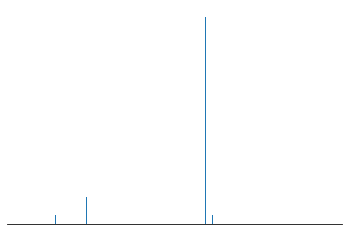

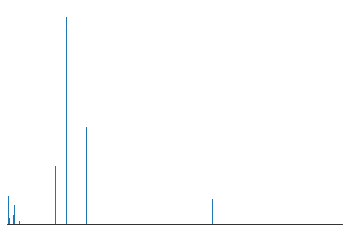

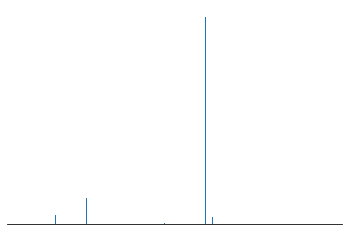

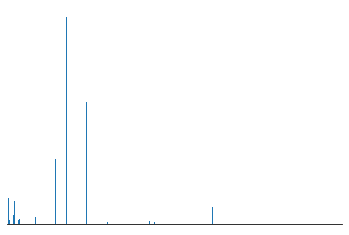

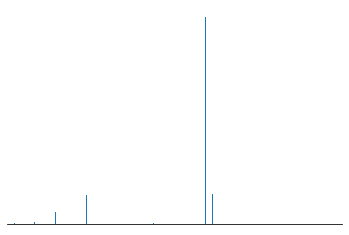

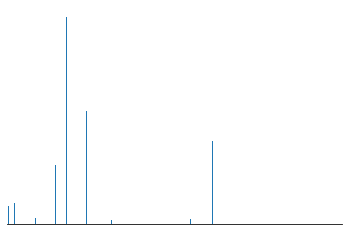

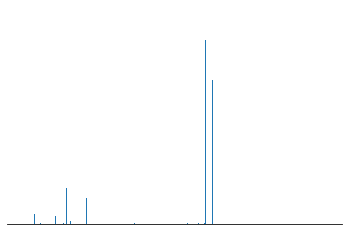

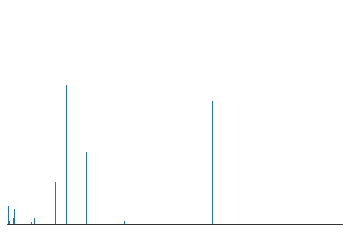

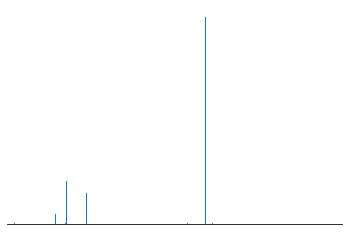

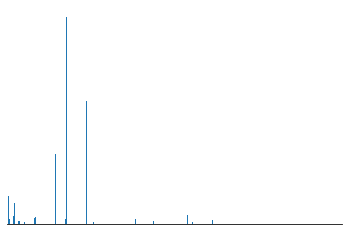

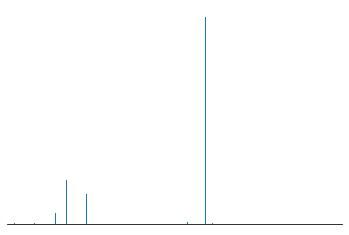

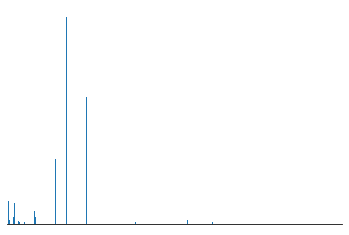

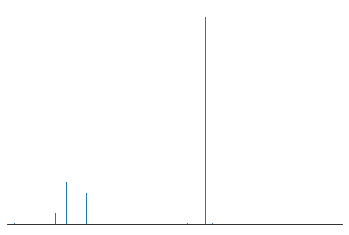

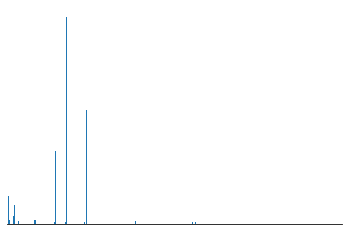

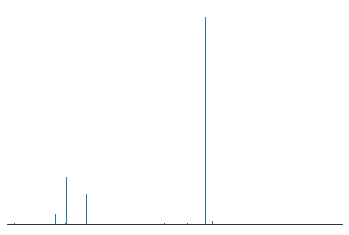

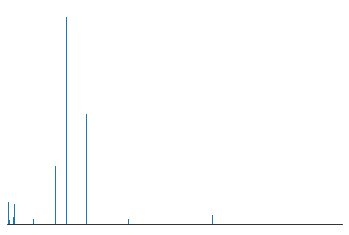

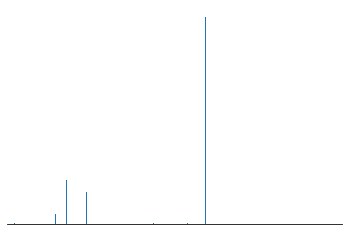

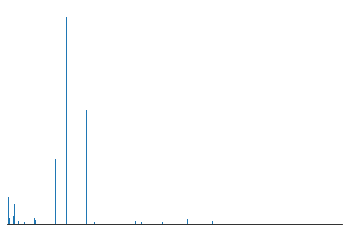

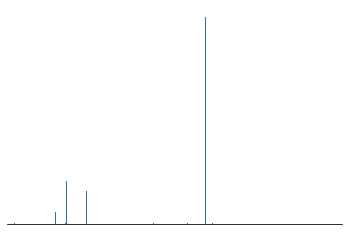

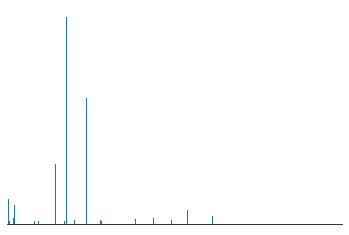

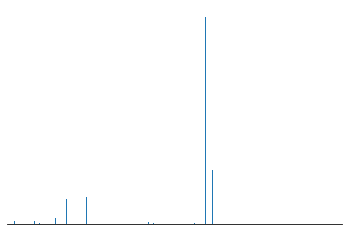

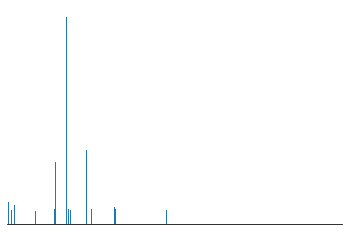

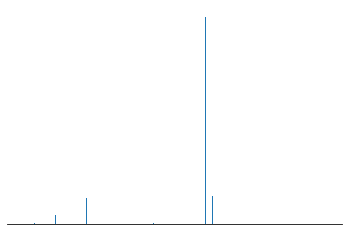

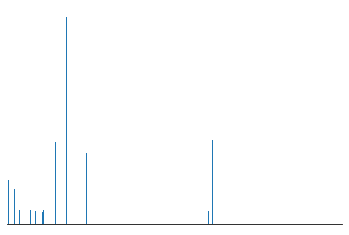

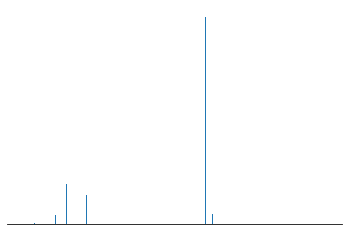

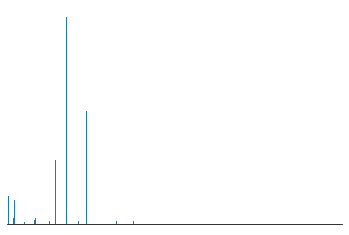

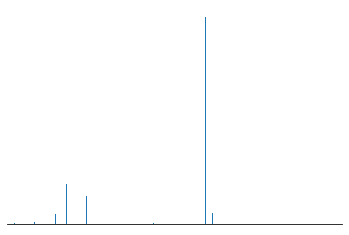

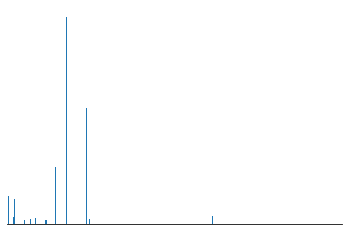

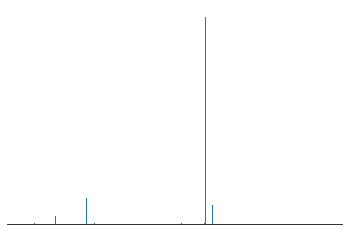

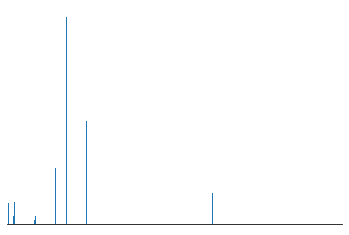

In [93]:
from ms2query.query_from_sqlite_database import get_metadata_from_sqlite
from ms2query.query_from_sqlite_database import get_spectra_from_sqlite

from ms2query.query_from_sqlite_database import get_inchikey_information

inchikey_info = get_inchikey_information(sqlite_file)


for i, query_spectrum in enumerate(test_spectra_without_match[2000:]):
    query_spectrum_id = query_spectrum.get("spectrum_id")
    query_spectrum_smiles = query_spectrum.get("smiles")
    query_spectrum_inchikey = query_spectrum.get("inchikey")[:14]
    
    best_result = results[query_spectrum_id].iloc[0]
    if best_result["ms2query_model_prediction"] > 0.8:
        print(i)

        best_analog = best_result.name
        
        analog_spectrum = get_spectra_from_sqlite(sqlite_file, [best_analog])[0]
        
        analog_smiles = analog_spectrum.get("smiles")
        analog_inchikey = analog_spectrum.get("inchikey")[:14]        

        tanimoto_score = tanimoto_scores.loc[query_spectrum_inchikey, analog_inchikey]

        print("Tanimoto score query-analog:" + str(tanimoto_score))
        print(best_result)


        print(query_spectrum_smiles)
        print(analog_smiles)
        
        plot_illustrative_mass_spectrum(query_spectrum, 200, 1000)
        plot_illustrative_mass_spectrum(analog_spectrum, 200, 1000)

        plot_molecule(query_spectrum_smiles)
        
        other_analogs = inchikey_info[1][analog_inchikey]
        for similar_analog_inchikey, tanimoto_score_analog in other_analogs:
            print("tanimoto_score_analog:" + str(tanimoto_score_analog))
            spectrum_ids = inchikey_info[0][similar_analog_inchikey]
            similar_analog_spectra = get_spectra_from_sqlite(sqlite_file, spectrum_ids)
            plot_molecule(similar_analog_spectra[0].get("smiles"))
            for spectrum in similar_analog_spectra:
                plot_illustrative_mass_spectrum(spectrum, 200, 1000)
        break
